## An√°lisis del laboratorio de masa

In [29]:
import pandas as pd
import numpy as np

In [30]:
# Import custom libraries
import warnings
import sys
import os

# Subir dos niveles desde notebooks/mod_tecnico/ hasta la ra√≠z del repo
repo_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  
sys.path.append(repo_path)

# Ahora intenta importar
from src.data_processing import ready_to_import

In [31]:
#Importar librerias para graficar
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
from plotly.subplots  import make_subplots

In [32]:
# Importamos lo necesario para trabajar con consultas SQL

from pandasql import sqldf

# Definir funci√≥n de consulta
pysqldf = lambda q: sqldf(q, globals())

#### Se carga el dataset 

In [33]:
# Import data from Excel files
url = "https://raw.githubusercontent.com/MiguelOscar-Insco/data-INSCO-hub/main/data/raw/masa_25.xlsx"
masa = pd.read_excel(url)


In [34]:
# Resumen estad√≠stico de la tabla
masa.describe()

lab_received_date        scheduled_delivery_date  \
count                            460                            453   
mean   2025-01-30 03:01:33.913043456  2025-02-18 19:23:26.622516480   
min              2024-11-06 00:00:00            2024-12-19 00:00:00   
25%              2025-01-14 00:00:00            2025-01-31 00:00:00   
50%              2025-01-28 00:00:00            2025-02-18 00:00:00   
75%              2025-02-25 00:00:00            2025-03-13 00:00:00   
max              2025-03-27 00:00:00            2025-04-04 00:00:00   
std                              NaN                            NaN   

                       cleaning_date               calibration_date  \
count                            473                            474   
mean   2025-01-31 02:23:05.200845568  2025-02-09 19:11:23.544303616   
min              2024-03-12 00:00:00            2024-03-13 00:00:00   
25%              2025-01-13 00:00:00            2025-01-23 00:00:00   
50%              2025-01-29 00:00:00            2025-02-10 00:00:00   
75%              2025-02-28 00:00:00            2025-03-09 06:00:00   
max              2025-03-28 00:00:00            2025-03-31 00:00:00   
std                              NaN                            NaN   

                       delivery_date  delivery_time  assigned_time  \
count                            479     479.000000     479.000000   
mean   2025-02-15 05:24:40.584551168       8.630480      12.283925   
min              2025-01-02 00:00:00       0.000000       0.000000   
25%              2025-01-24 00:00:00       5.000000      11.000000   
50%              2025-02-11 00:00:00       8.000000      12.000000   
75%              2025-03-11 00:00:00      11.000000      15.000000   
max              2025-03-31 00:00:00      44.000000      30.000000   
std                              NaN       5.928019       5.245318   

       piece_count  
count   479.000000  
mean      5.102296  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       3.000000  
max      58.000000  
std       8.710834

In [35]:
# Seleccionamos las columnas que contienen fechas y las convertimos a tipo datetime
col_fechas = [col for col in masa.columns if 'date' in col.lower() or 'fecha' in col.lower()]

for col in col_fechas:
    masa[col] = pd.to_datetime(masa[col], errors='coerce', format='%Y/%m/%d')

In [36]:
masa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            460 non-null    object        
 1   so                       479 non-null    object        
 2   assignee                 585 non-null    object        
 3   calibrator               479 non-null    object        
 4   supervisor               479 non-null    object        
 5   approver                 479 non-null    object        
 6   classification           479 non-null    object        
 7   lab_received_date        460 non-null    datetime64[ns]
 8   scheduled_delivery_date  453 non-null    datetime64[ns]
 9   cleaning_date            473 non-null    datetime64[ns]
 10  calibration_date         474 non-null    datetime64[ns]
 11  delivery_date            479 non-null    datetime64[ns]
 12  delivery_time            479 non-nul

In [37]:
# Se hace una copia de la tabla para evitar problemas de referencia
mass = masa.copy()

**Se eliminan las filas donde 'report_number' es NaN y se une el contenido de 'assignee' de las filas con 'report_number' NaN a la fila anterior**

In [38]:
# Esta funci√≥n es interna y creada para el proceso en el que se va a usar
mass = ready_to_import.to_prepare_db(mass)
# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            460 non-null    object        
 1   so                       460 non-null    object        
 2   assignee                 460 non-null    object        
 3   calibrator               460 non-null    object        
 4   supervisor               460 non-null    object        
 5   approver                 460 non-null    object        
 6   classification           460 non-null    object        
 7   lab_received_date        460 non-null    datetime64[ns]
 8   scheduled_delivery_date  453 non-null    datetime64[ns]
 9   cleaning_date            454 non-null    datetime64[ns]
 10  calibration_date         455 non-null    datetime64[ns]
 11  delivery_date            460 non-null    datetime64[ns]
 12  delivery_time            460 non-nul

## Agregamos columnas temporales segmentadas

In [39]:
# Crear columnas derivadas de la fecha de recepci√≥n
mass['year_received'] = mass['lab_received_date'].dt.year
mass['month_received'] = mass['lab_received_date'].dt.month
mass['week_received'] = mass['lab_received_date'].dt.isocalendar().week

# Crear columnas derivadas de la fecha de entrega
mass['year_delivery'] = mass['delivery_date'].dt.year
mass['month_delivery'] = mass['delivery_date'].dt.month
mass['week_delivery'] = mass['delivery_date'].dt.isocalendar().week

In [40]:
approver = pysqldf("""
SELECT report_number, COUNT(report_number) AS count
FROM mass
GROUP BY report_number
HAVING COUNT(report_number) > 1
""")
approver

report_number  count
0   CCM0014.M/2025      2
1   CCM0015.M/2025      2
2   CCM0016.M/2025      2
3   CCM0042.M/2025      2
4   CCM0045.M/2025      3
5   CCM0061.M/2025      5
6   CCM0089.M/2025      2
7   CCM0090.M/2025      2
8   CCM0138.M/2025      2
9   CCM0167.M/2025      2
10  CCM0198.M/2025      2
11  CCM0199.M/2025      2
12  CCM0282.M/2025      2
13  CCM0305.M/2025      2
14  RSM0003.M/2025     52
15  RSM0004.M/2025      2
16  RSM0005.M/2025      3
17  RSM0006.M/2025      2

In [41]:
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            460 non-null    object        
 1   so                       460 non-null    object        
 2   assignee                 460 non-null    object        
 3   calibrator               460 non-null    object        
 4   supervisor               460 non-null    object        
 5   approver                 460 non-null    object        
 6   classification           460 non-null    object        
 7   lab_received_date        460 non-null    datetime64[ns]
 8   scheduled_delivery_date  453 non-null    datetime64[ns]
 9   cleaning_date            454 non-null    datetime64[ns]
 10  calibration_date         455 non-null    datetime64[ns]
 11  delivery_date            460 non-null    datetime64[ns]
 12  delivery_time            460 non-nul

### Comparamos la cantidad de calibraciones con los mantenimientos

In [42]:
# Clasificar por tipo de servicio
mass['service_type'] = np.where(
    mass['report_number'].str.startswith('RSM', na=False),
    'Mantenimiento',
    np.where(
        mass['report_number'].str.startswith('CCM', na=False),
        'Calibraci√≥n',
        'Otros'  # Valor por defecto si ninguna condici√≥n se cumple
    )
)

#### Mostramos un dataset con los tipos de servicio

In [43]:
no_errors = mass[mass['substitution_reason'].isnull()]
no_errors.head(10)

report_number     so                            assignee  \
0     CCM0001.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
1     CCM0002.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
2     CCM0003.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
3     CCM0004.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
4  CCM0005.M/2025 v0  I0082  Leobardo Maximiliano Brito Fonseca   
5  CCM0005.M/2025 v1  H2381  Leobardo Maximiliano Brito Fonseca   
6     CCM0006.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
7     CCM0007.M/2025  H2395            Francisco Torres Cabrera   
8     CCM0008.M/2025  H2403              Guillermo Guzm√°n L√≥pez   
9     CCM0009.M/2025  H2403              Guillermo Guzm√°n L√≥pez   

                           calibrator                          supervisor  \
0  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
1  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
2  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
3  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
4  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
5  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
6  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
7            Francisco Torres Cabrera  Leobardo Maximiliano Brito Fonseca   
8              Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   
9              Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   

                             approver classification lab_received_date  \
0            Gabriel Gallardo Camacho             E2        2024-12-05   
1            Gabriel Gallardo Camacho             E2        2024-12-05   
2            Gabriel Gallardo Camacho             E2        2024-12-05   
3            Gabriel Gallardo Camacho             E2        2024-12-05   
4            Gabriel Gallardo Camacho             E2        2025-01-21   
5            Gabriel Gallardo Camacho             E2        2024-12-05   
6            Gabriel Gallardo Camacho             E2        2024-12-05   
7  Leobardo Maximiliano Brito Fonseca             E2        2024-12-06   
8  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   
9  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   

  scheduled_delivery_date cleaning_date  ...  \
0              2025-01-06    2024-12-06  ...   
1              2025-01-06    2024-12-06  ...   
2              2025-01-06    2024-12-06  ...   
3              2025-01-06    2024-12-06  ...   
4              2025-01-31    2025-01-21  ...   
5              2025-01-06    2024-12-06  ...   
6              2025-01-06    2024-12-06  ...   
7              2025-01-08    2024-12-06  ...   
8              2025-01-06    2025-01-02  ...   
9              2025-01-06    2025-01-02  ...   

                                    lab_observations   priority  piece_count  \
0                                                NaN  ORDINARIO          1.0   
1                                                NaN  ORDINARIO          1.0   
2                                                NaN  ORDINARIO          1.0   
3                                                NaN  ORDINARIO          1.0   
4  Me dan otra pesa para calibrarla y esta si cum...  ORDINARIO          1.0   
5  Pesa de venta no cumple con la clese E2. cuand...  ORDINARIO          1.0   
6                                                NaN  ORDINARIO          1.0   
7                                                NaN  ORDINARIO         22.0   
8                                                NaN  ORDINARIO          4.0   
9                                                NaN  ORDINARIO          3.0   

  year_received  month_received week_received year_delivery month_delivery  \
0          2024              12            49          2025              1   
1          2024              12 

In [44]:
service_type = no_errors['service_type'].value_counts()
service_type

service_type
Calibraci√≥n      363
Mantenimiento     72
Name: count, dtype: int64

#### Mostramos un gr√°fico de barras con los tipos de servicio

In [45]:
import plotly.graph_objects as go

fig = go.Figure(data=[ 
    go.Pie(
        labels=service_type.index, 
        values=service_type.values, 
        rotation=57,
        direction='clockwise',
        hole=0.3, 
        textinfo='percent',  # Muestra el porcentaje y el nombre
        hoverinfo='label+value',  # Muestra nombre y porcentaje al pasar el mouse
        insidetextorientation='radial',
        marker=dict(
            colors=['#66b3ff', '#99ff99', '#ff6666', '#ffcc99'],  # Puedes ajustar estos colores
        ),
        #pull=[0.1, 0, 0, 0],  # Hace "salir" ligeramente la primera porci√≥n (opcional)
    )
])

fig.update_layout(
    template="plotly+seaborn",  # Combina los templates de plotly y seaborn
    width=600,
    height=500,
    title='Distribuci√≥n de Tipos de Servicios',
    title_x=0.5,
    title_font=dict(size=20, family='Verdana, sans-serif'),
    legend_title_text="Servicios",
    legend=dict(
        x=0.8, y=1.1,
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="Black",
        borderwidth=1
    ),
    showlegend=True,
)

fig.show()

### La gr√°fica de barras muestra que la mayor√≠a de los servicios son calibraciones (386), en comparaci√≥n con los mantenimientos, que son solo 74. 

#### A√±adir una columna para clasificar los equipos por tipos

In [46]:
classification_map = {
    'I': 'Balanza', 'II': 'Balanza', 'III': 'Balanza', 'IIII': 'Balanza',
    'E1': 'Pesa', 'E2': 'Pesa', 'F1': 'Pesa', 'F2': 'Pesa',
    'M1': 'Pesa', 'M2': 'Pesa', 'M3': 'Pesa',
    '1': 'Pesa', '2': 'Pesa', '3': 'Pesa', '4': 'Pesa',
    '5': 'Pesa', '6': 'Pesa',
    'M': 'NBS', 'S': 'NBS', 'S-1': 'NBS', 'P': 'NBS', 'Q': 'NBS',
    'T': 'NBS', 'F': 'NBS',
    'ONN': 'ONN'
}

# Asignar valores usando map()
mass['equipment_type'] = mass['classification'].map(classification_map).fillna('Otros')

## An√°lisis de los matentimientos

In [47]:
# Obtenemos los reportes de mantenimiento
mass_maintenance = mass[mass['report_number'].str.startswith('RSM', na=False)]
mass_maintenance.head()

report_number     so                                           assignee  \
386  RSM0001.M/2025  H2403                             Guillermo Guzm√°n L√≥pez   
387  RSM0002.M/2025  H2403                             Guillermo Guzm√°n L√≥pez   
388  RSM0003.M/2025  I0036  Guillermo Guzm√°n L√≥pez, Mario de Jes√∫s Garc√≠a,...   
389  RSM0003.M/2025  I0036  Guillermo Guzm√°n L√≥pez, Mario de Jes√∫s Garc√≠a,...   
390  RSM0003.M/2025  I0036  Guillermo Guzm√°n L√≥pez, Mario de Jes√∫s Garc√≠a,...   

                 calibrator                          supervisor  \
386  Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   
387  Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   
388   Mario de Jes√∫s Garc√≠a  Leobardo Maximiliano Brito Fonseca   
389   Mario de Jes√∫s Garc√≠a  Leobardo Maximiliano Brito Fonseca   
390   Mario de Jes√∫s Garc√≠a  Leobardo Maximiliano Brito Fonseca   

                               approver classification lab_received_date  \
386  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   
387  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   
388  Leobardo Maximiliano Brito Fonseca             M1        2025-01-14   
389  Leobardo Maximiliano Brito Fonseca             M1        2025-01-14   
390  Leobardo Maximiliano Brito Fonseca             M1        2025-01-14   

    scheduled_delivery_date cleaning_date  ...   priority piece_count  \
386              2025-01-06    2025-01-02  ...  ORDINARIO         4.0   
387              2025-01-06    2025-01-02  ...  ORDINARIO         3.0   
388              2025-02-05    2025-01-20  ...  ORDINARIO         1.0   
389              2025-02-05    2025-01-20  ...  ORDINARIO         1.0   
390              2025-02-05    2025-01-20  ...  ORDINARIO         1.0   

     year_received month_received  week_received year_delivery month_delivery  \
386           2024             12             50          2025              1   
387           2024             12             50          2025              1   
388           2025              1              3          2025              1   
389           2025              1              3          2025              1   
390           2025              1              3          2025              1   

    week_delivery   service_type  equipment_type  
386             2  Mantenimiento            Pesa  
387             2  Mantenimiento            Pesa  
388             4  Mantenimiento            Pesa  
389             4  Mantenimiento            Pesa  
390             4  Mantenimiento            Pesa  

[5 rows x 28 columns]

In [48]:
# Contamos la cantidad de reportes por tipo de equipo
mass_maintenance['equipment_type'].value_counts()

equipment_type
Pesa       66
Balanza     8
Name: count, dtype: int64

In [49]:
loc_eq = (mass_maintenance.groupby(['service_location', 'equipment_type'])['report_number']
          .count()
          .unstack()
          .fillna(0)
          .sort_values('Pesa', ascending=False)
          .rename(
            columns={
                'Pesa': 'Pesa',
                'Balanza': 'Balanza'
            }
)
        )
if 'index' not in loc_eq.columns:
  loc_eq.reset_index(inplace=True)
  loc_eq.rename(columns={'service_location': 'Ubicaci√≥n'}, inplace=True)
loc_eq

equipment_type Ubicaci√≥n  Balanza  Pesa
0                    LAB      0.0  66.0
1                  SITIO      8.0   0.0

In [50]:
# Contamos la cantidad de reportes por tipo de equipo
maintenance_per_type = mass_maintenance.groupby('equipment_type')['report_number'].count().sort_values(ascending=False)
maintenance_per_type

equipment_type
Pesa       66
Balanza     8
Name: report_number, dtype: int64

In [51]:
loc_eq_melted = loc_eq.melt(id_vars=['Ubicaci√≥n'], var_name='Equipo', value_name='Total').sort_values('Total', ascending=False)
loc_eq_melted

Ubicaci√≥n   Equipo  Total
2       LAB     Pesa   66.0
1     SITIO  Balanza    8.0
0       LAB  Balanza    0.0
3     SITIO     Pesa    0.0

### Gr√°fico de barras con los servicios de mantenimiento clasificados por tipo

In [52]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Crea el subplot: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.3, 0.7],
    specs=[[{"type": "table"}, {"type": "domain"}]]
)

# A√±ade la tabla
fig.add_trace(
    go.Table(
        header=dict(
            values=loc_eq.columns,
            fill_color='paleturquoise',
            align='center'
        ),
        cells=dict(
            values=loc_eq.values.T,
            fill_color='lavender',
            align='center'
        )
    ),
    row=1, col=1
)

# A√±ade el gr√°fico de pastel
fig.add_trace(
    go.Pie(
        labels=maintenance_per_type.index,
        values=maintenance_per_type.values,
        hole=0.3,
        textinfo='percent',
        hoverinfo='label+value',
        marker=dict(colors=['#66b3ff', '#99ff99', '#ff6666', '#ffcc99']),
    ),
    row=1, col=2
)

# Ajustes finales
fig.update_layout(
    title_text="Clasificaci√≥n de mantenimientos por tipo de equipo",
    height=500,
    width=1000,
    template="seaborn"
)

fig.show()


**El gr√°fico muestra que en el primer trimestre del a√±o el laboratorio le ha dado mantenimiento a 66 pesas y 8 balanzas.**

## Cantidad de mantenimientos por meses y tipos de equipos

In [53]:
mass_maintenance.columns

Index(['report_number', 'so', 'assignee', 'calibrator', 'supervisor',
       'approver', 'classification', 'lab_received_date',
       'scheduled_delivery_date', 'cleaning_date', 'calibration_date',
       'delivery_date', 'delivery_time', 'process_status', 'assigned_time',
       'service_location', 'substitution_reason', 'lab_observations',
       'priority', 'piece_count', 'year_received', 'month_received',
       'week_received', 'year_delivery', 'month_delivery', 'week_delivery',
       'service_type', 'equipment_type'],
      dtype='object')

In [54]:
# Contamos la cantidad de reportes por clasificaci√≥n
maint_ext = mass_maintenance[['report_number', 'classification','assignee', 'delivery_date', 'assigned_time', 'delivery_time', 'piece_count', 'equipment_type', 'week_delivery']].copy()
maint_ext['month_deliv_name'] = maint_ext['delivery_date'].dt.month_name(locale='es')


# Contamos la cantidad de reportes por mes y tipo de equipo
maint_month_type = (maint_ext.groupby(['month_deliv_name', 'equipment_type'])['piece_count']
        .sum()
        .unstack()
        .fillna(0)
        #.sort_values(('piece_count', 'Pesa'), ascending=False) # Correcci√≥n en la columna de ordenamiento
        .rename(
            columns={
                'Pesa': 'Pesa',
                'Balanza': 'Balanza'
            }
        )
        )

if 'index' not in maint_month_type.columns:
  maint_month_type.reset_index(inplace=True)
  maint_month_type.rename(columns={'month_deliv_name': 'Mes'}, inplace=True)

maint_mt_melted = maint_month_type.melt(id_vars=['Mes'], var_name='Equipo', value_name='Total').sort_values('Total', ascending=False)

In [55]:
maint_mt_melted = maint_month_type.melt(id_vars=['Mes'], var_name='Equipo', value_name='Total').sort_values('Total', ascending=False)
    
maint_mt_melted

Mes   Equipo  Total
3    Enero     Pesa  167.0
5    Marzo     Pesa   33.0
4  Febrero     Pesa   14.0
2    Marzo  Balanza    6.0
1  Febrero  Balanza    2.0
0    Enero  Balanza    0.0

In [56]:
# Crea el subplot: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.3, 0.8],
    specs=[[{"type": "table"}, {"type": "bar"}]],
    horizontal_spacing=0.1  # Espaciado entre tabla y gr√°fico
)

# A√±ade la tabla
fig.add_trace(
    go.Table(
        header=dict(
            values=maint_month_type.columns,
            fill_color='paleturquoise',
            align='center',
            line_color='darkslategray'
        ),
        cells=dict(
            values=maint_month_type.values.T,
            fill_color='lavender',
            align='center',
            line_color='darkslategray'
        )
    ),
    row=1, col=1
)

# Configuraci√≥n del gr√°fico de barras apiladas
color_sequence = ['#66b3ff', '#90fa99']
month_order = ['Enero', 'Febrero', 'Marzo', 'Abril']

# A√±adir cada equipo como barra apilada
for i, equipo in enumerate(maint_mt_melted['Equipo'].unique()):
    subset = maint_mt_melted[maint_mt_melted['Equipo'] == equipo]
    
    # Filtrar texto solo para valores mayores a 0
    texto_barras = np.where(subset['Total'] > 0, 
                          subset['Total'].round().astype(int).astype(str), 
                          '')
    
    fig.add_trace(go.Bar(
        x=subset['Mes'],
        y=subset['Total'],
        name=equipo,
        marker_color=color_sequence[i % len(color_sequence)],
        text=texto_barras,  # Usamos el texto filtrado
        textposition='outside',
        texttemplate='<b>%{text}</b>',  # Texto en negrita
        textfont=dict(size=12, color='black'),
        hovertemplate=(
            '<b>Tipo:</b> %{fullData.name}<br>'
            '<b>Mes:</b> %{x}<br>'
            '<b>Cantidad:</b> %{y}<extra></extra>'
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family="Arial"
        )
    ), row=1, col=2)

# Resto del c√≥digo permanece igual...

# Configurar layout para barras apiladas
fig.update_layout(
    title="Mantenimientos totales por meses y tipos de equipos",
    xaxis_title="Mes",
    yaxis_title="N√∫mero de mantenimientos",
    legend_title="Tipo de Equipo",
    template="plotly",
    barmode='stack',
    margin=dict(l=20, r=20, t=50, b=20),
    showlegend=True,
    uniformtext_minsize=10  # Tama√±o m√≠nimo para el texto
)

# Ordenar los meses y ajustar eje X
fig.update_xaxes(
    categoryorder='array',
    categoryarray=month_order,
    row=1, col=2
)

fig.update_yaxes(
    rangemode='tozero',
    row=1, col=2
)

fig.show()

**An√°lisis Descriptivo:**
* **Enero:** Se observa una cantidad significativamente mayor de mantenimientos en Enero (167 piezas en total). Este mes est√° compuesto √∫nicamente por mantenimientos realizados en equipos tipo "Pesa".
* **Febrero:** La cantidad total de mantenimientos disminuye dr√°sticamente en Febrero, con un total de 16 mantenimientos. De estos, 14 corresponden a equipos tipo "Pesa" y 2 a equipos tipo "Balanza".
* **Marzo:** El n√∫mero total de mantenimientos aumenta en Marzo a 39. Este mes presenta una distribuci√≥n con 33 mantenimientos realizados en equipos tipo "Pesa" y 6 en equipos tipo "Balanza".

### Agrupamos los mantenimientos por su clasificaci√≥n

In [57]:
# Cantidad de mantenimientos por clasificaci√≥n
maintenance_class = mass_maintenance.groupby('classification')['report_number'].count().sort_values(ascending=False)
maintenance_class

classification
M1     61
M2      5
I       4
II      3
III     1
Name: report_number, dtype: int64

### Gr√°fico de barras con los servicios de mantenimiento agrupados por clasificaci√≥n

In [58]:
colors = ['#66b3ff'] * 5
colors[0] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=maintenance_class.index,
    y=maintenance_class.values,
    marker_color=colors,
    text=maintenance_class.values,
    textposition='outside',
    name='N√∫mero de Mantenimientos' # A√±ade un nombre para la leyenda
)])

fig.update_layout(
    title_text='Informes de mantenimiento por clasificaci√≥n',
    width=800,  # Cambia el ancho del gr√°fico
    height=600, # Cambia la altura del gr√°fico
    xaxis_title= 'Clasificaci√≥n',
    yaxis_title= 'Cantidad',
    legend_title_text='Variable', # T√≠tulo de la leyenda
    legend=dict(
        orientation="h",      # Orientaci√≥n horizontal de la leyenda
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

- El gr√°fico muestra que las pesas del tipo *M1* son las que m√°s mantenimiento han recibido, con un total de 61 servicios. 
- Las balanzas del tipo *III* son las que menos mantenimiento han recibido, con solo 1 servicio.

### Analizamos los mantenimientos teniendo en cuenta su clasificaci√≥n y la comparativa con sus tiempos asignados y de entrega.

In [59]:
maint = pysqldf("""
SELECT classification, COUNT(report_number) AS rep_qty, SUM(piece_count) AS total_pieces, AVG(delivery_time) AS deliv_time_avg
FROM mass_maintenance
GROUP BY classification
ORDER BY rep_qty DESC
""")
maint

classification  rep_qty  total_pieces  deliv_time_avg
0             M1       61         150.0        8.377049
1             M2        5          64.0        8.000000
2              I        4           4.0        3.000000
3             II        3           3.0        3.000000
4            III        1           1.0        2.000000

In [60]:
maintenance_time = (mass_maintenance.groupby('classification')[['delivery_time', 'assigned_time', 'piece_count']]
                                               .mean().round(2)
                                               #.unstack(fill_value=0)
                                               #.reset_index()
                                               .sort_values('assigned_time', ascending=False)
                                               )  

'''maintenance_time = maintenance_time.rename(
    columns={
        'Tiempo_Entrega': 'delivery_time' ,
        'Tiempo_Asignaci√≥n':'assigned_time',
        'Cantidad_Piezas':'piece_count'
    }
)'''
maintenance_time

delivery_time  assigned_time  piece_count
classification                                           
M1                       8.38          14.66         2.46
M2                       8.00           9.60        12.80
III                      2.00           5.00         1.00
I                        3.00           3.75         1.00
II                       3.00           3.33         1.00

In [61]:
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df1 = maint.reset_index().sort_values('total_pieces', ascending=False)
df2 = maintenance_time.reset_index().sort_values('assigned_time', ascending=False)

# Crear figura con 1 fila y 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}]],
    column_widths=[0.5, 0.5],
    horizontal_spacing=0.1,
    subplot_titles=(
        "Comparaci√≥n de reportes y piezas", 
        "Tiempo de entrega vs tiempo asignado"
    )
)

# ==============================================
# PRIMER GR√ÅFICO (IZQUIERDA)
# ==============================================
# Barras para cantidad de reportes
fig.add_trace(
    go.Bar(
        x=df1['classification'],
        y=df1['rep_qty'],
        name='Reportes',
        marker_color='#66b3ff',
        text=[f'{val:.0f}' for val in df1['rep_qty']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>'
            '<b>Reportes:</b> %{y:.0f}<extra></extra>'
        )
    ),
    row=1, col=1, secondary_y=False
)

# Barras para cantidad de piezas
fig.add_trace(
    go.Bar(
        x=df1['classification'],
        y=df1['total_pieces'],
        name='Piezas',
        marker_color='#99ff99',
        text=[f'{val:.0f}' for val in df1['total_pieces']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>'
            '<b>Piezas:</b> %{y:.0f}<extra></extra>'
        )
    ),
    row=1, col=1, secondary_y=False
)

# L√≠nea para tiempo de entrega promedio
fig.add_trace(
    go.Scatter(
        x=df1['classification'],
        y=df1['deliv_time_avg'],
        mode='lines+markers',
        name='Tiempo Entrega',
        line=dict(color='black', dash='dash'),
        marker=dict(symbol='circle', size=8),
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>'
            '<b>Tiempo:</b> %{y:.1f} d√≠as<extra></extra>'
        )
    ),
    row=1, col=1, secondary_y=True
)

# ==============================================
# SEGUNDO GR√ÅFICO (DERECHA)
# ==============================================
# Barras tiempo de entrega
fig.add_trace(
    go.Bar(
        x=df2['classification'],
        y=df2['delivery_time'],
        name='Entrega',
        marker_color='#0e56cd',
        text=[f'{val:.1f}' for val in df2['delivery_time']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>'
            '<b>Tiempo Entrega:</b> %{y:.1f}<extra></extra>'
        )
    ),
    row=1, col=2, secondary_y=False
)

# Barras tiempo asignado
fig.add_trace(
    go.Bar(
        x=df2['classification'],
        y=df2['assigned_time'],
        name='Asignado',
        marker_color='#21c321',
        text=[f'{val:.1f}' for val in df2['assigned_time']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>'
            '<b>Tiempo Asignado:</b> %{y:.1f}<extra></extra>'
        )
    ),
    row=1, col=2, secondary_y=False
)

# L√≠nea promedio de piezas
fig.add_trace(
    go.Scatter(
        x=df2['classification'],
        y=df2['piece_count'],
        mode='lines+markers',
        name='Piezas',
        line=dict(color='black', dash='dot'),
        marker=dict(symbol='diamond', size=8),
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>'
            '<b>Promedio Piezas:</b> %{y:.1f}<extra></extra>'
        )
    ),
    row=1, col=2, secondary_y=True
)

# ==============================================
# ANOTACIONES PARA RAZONES
# ==============================================
annotations = []
for i, row in df1.iterrows():
    if row['rep_qty'] > 0:  # Evitar divisi√≥n por cero
        ratio = row['total_pieces'] / row['rep_qty']
        if ratio > 1:
            annotations.append(dict(
                x=row['classification'],
                y=max(row['rep_qty'], row['total_pieces']),
                xref="x1",
                yref="y1",
                text=f'Raz√≥n: {ratio:.2f}',
                showarrow=True,
                arrowhead=3,
                font=dict(color='red'),
                ax=20,
                ay=-30
            ))

# ==============================================
# CONFIGURACI√ìN FINAL
# ==============================================
fig.update_layout(
    height=600,
    width=1200,
    barmode='group',
    annotations=annotations,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    ),
    margin=dict(t=100, b=150),  # Margen aumentado para ejes
    xaxis=dict(tickangle=-30),  # Inclinaci√≥n etiquetas eje X
    xaxis2=dict(tickangle=-30)  # Inclinaci√≥n para segundo gr√°fico
)

# Configurar ejes X
fig.update_xaxes(
    title_text="Clasificaci√≥n del Equipo",
    showticklabels=True,
    row=1, 
    col=1,
    tickfont=dict(size=12)
)

fig.update_xaxes(
    title_text="Clasificaci√≥n del Equipo",
    showticklabels=True,
    row=1, 
    col=2,
    tickfont=dict(size=12)
)

# Configurar ejes Y
fig.update_yaxes(title_text="Cantidad", secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text="Tiempo (d√≠as)", secondary_y=True, row=1, col=1)
fig.update_yaxes(title_text="Tiempo", secondary_y=False, row=1, col=2)
fig.update_yaxes(title_text="Piezas", secondary_y=True, row=1, col=2)

# T√≠tulo general
fig.add_annotation(
    text="An√°lisis de Mantenimientos",
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.25,
    showarrow=False,
    font=dict(size=20, color='black')
)

fig.show()

## ‚úÖ Eficiencia en los Tiempos de Entrega

- En la mayor√≠a de los casos, se completan los servicios de mantenimiento en un tiempo considerablemente menor al que se les asigna.  
- Esto indica que el laboratorio opera con holgura en su planificaci√≥n, lo cual puede verse como una oportunidad para **optimizar los tiempos asignados y mejorar la eficiencia operativa**.  
- Reducir los m√°rgenes conservadores en la planificaci√≥n puede liberar recursos y permitir una mayor capacidad de atenci√≥n.

---

## ‚úÖ An√°lisis por Categor√≠a de Pesas: M1 y M2

- **M1:**  
  - Es la categor√≠a con mayor n√∫mero de informes (61), representando una alta demanda.  
  - En promedio, cada informe incluye unas **2.46 pesas**, lo que sugiere que se manejan vol√∫menes moderados por servicio.  
  - Esto permite una atenci√≥n √°gil y constante por parte del personal t√©cnico.

- **M2:**  
  - Aunque tiene menos informes, cada uno involucra un volumen considerablemente mayor, con un **promedio de 12.80 pesas por servicio**.  
  - Este comportamiento sugiere una mayor complejidad t√©cnica, que justifica los tiempos asignados.  
  - Aun as√≠, los tiempos reales de entrega no se ven comprometidos, lo cual demuestra **una buena capacidad de respuesta ante solicitudes m√°s complejas**.

---

## ‚úÖ Oportunidades de Mejora en la Planificaci√≥n

- Dado que el tiempo efectivo es consistentemente menor que el tiempo asignado, **se evidencia una subutilizaci√≥n de recursos**.  
- Esto abre la puerta a una redistribuci√≥n m√°s eficiente del personal o a la **posibilidad de atender m√°s √≥rdenes sin comprometer la calidad**.  
- Ajustar los tiempos asignados a la realidad observada contribuir√≠a a una planificaci√≥n m√°s precisa y menos conservadora.

---

## üí° Recomendaciones Estrat√©gicas

1. **Revisar los Tiempos Asignados por Tipo de Categor√≠a:**  
   Evaluar si es viable reducirlos para mejorar la rotaci√≥n de servicios.

2. **Analizar la Relaci√≥n entre Volumen de Pesas y Tiempo de Entrega:**  
   Confirmar si el n√∫mero de pesas enviadas por los clientes influye significativamente en el desempe√±o del laboratorio, principalmente con los servicios de calibraci√≥n.

3. **Centralizar Procesos en Casos de Alta Carga (como M2):**  
   Dado que estas √≥rdenes manejan muchas pesas, podr√≠a ser √∫til desarrollar flujos especializados para mantener la eficiencia.

4. **Monitoreo Continuo de Indicadores Operativos:**  
   Implementar dashboards o reportes peri√≥dicos para vigilar tiempos de entrega y carga de trabajo por categor√≠a.

---

## üìå Conclusi√≥n General

El laboratorio de calibraci√≥n de masa muestra una **alta eficiencia operativa**, cumpliendo los servicios en menos tiempo del previsto incluso cuando se manejan grandes vol√∫menes de pesas por informe. A pesar de las diferencias en complejidad entre categor√≠as, los tiempos de entrega se mantienen estables. Existe margen para **ajustar la planificaci√≥n y aumentar la productividad sin comprometer la calidad del servicio**.


# Realizar el an√°lisis de las calibraciones

### Eliminamos todos los reportes que no son calibraciones

In [111]:
# Se eliminan las filas que no son calibraciones
mass_cal = mass[~mass['report_number'].str.startswith('RSM', na=False)]

In [112]:
# Analizamos la informaci√≥n de la tabla
mass_cal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386 entries, 0 to 385
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            386 non-null    object        
 1   so                       386 non-null    object        
 2   assignee                 386 non-null    object        
 3   calibrator               386 non-null    object        
 4   supervisor               386 non-null    object        
 5   approver                 386 non-null    object        
 6   classification           386 non-null    object        
 7   lab_received_date        386 non-null    datetime64[ns]
 8   scheduled_delivery_date  381 non-null    datetime64[ns]
 9   cleaning_date            380 non-null    datetime64[ns]
 10  calibration_date         386 non-null    datetime64[ns]
 11  delivery_date            386 non-null    datetime64[ns]
 12  delivery_time            386 non-null    

In [114]:
mass_cal.isnull().sum()

report_number                0
so                           0
assignee                     0
calibrator                   0
supervisor                   0
approver                     0
classification               0
lab_received_date            0
scheduled_delivery_date      5
cleaning_date                6
calibration_date             0
delivery_date                0
delivery_time                0
process_status               0
assigned_time                0
service_location             0
substitution_reason        363
lab_observations           335
priority                     0
piece_count                  0
year_received                0
month_received               0
week_received                0
year_delivery                0
month_delivery               0
week_delivery                0
service_type                 0
equipment_type               0
dtype: int64

# An√°lisis del DataFrame

**üìå Estructura General**  
- **386 registros** | **28 columnas** 
**üîç Hallazgos Clave**  
1. **Variables Temporales** (completas en su mayor√≠a):  
   - `delivery_time` (tiempo de entrega) y `assigned_time` - **0 nulos**  
   - Fechas cr√≠ticas (`lab_received_date`, `calibration_date`, `delivery_date`) - **100% completas**  
   - `scheduled_delivery_date` y `cleaning_date` - **5-6 nulos**  

2. **Columnas con Datos Faltantes**:  
   - `substitution_reason` (94% nulos) y `lab_observations` (87% nulos) - **Considerar eliminar o imputar**  

3. **Variables Categ√≥ricas Relevantes**:  
   - `classification`, `priority`, `service_type`, `equipment_type` - **0 nulos**  
   - √ötiles para segmentaci√≥n (ej: an√°lisis por tipo de equipo o prioridad).  

**‚ö†Ô∏è Siguientes acciones**  
- Limpieza m√≠nima: Revisar filas con `scheduled_delivery_date` nulo.  
- Enfoque anal√≠tico: **`delivery_time` vs categor√≠as** (prioridad, tipo de servicio).  
- Columnas opcionales: `substitution_reason` y `lab_observations` aportan poco valor.  


# An√°lisis de los errores de sustituci√≥n antes de realizar el an√°lisis de las calibraciones

In [116]:
# Obtenemos la cantidad de reportes por cada raz√≥n de sustituci√≥n
subs_reason = mass_cal.groupby('substitution_reason')['report_number'].count().sort_values(ascending=False)
subs_reason


substitution_reason
Solicitud del cliente           14
Error de laboratorio             6
Error del √°rea comercial         2
Error de atenci√≥n al cliente     1
Name: report_number, dtype: int64

### Se comparan los distintos tipos de errores de sustituci√≥n

In [153]:
import plotly.express as px

# Asumimos que subs_reason ya est√° definido
# Calcular el total de sustituciones
total = len(mass_cal['report_number'].unique())

# Calcular los porcentajes
percentages = [(v / total) * 100 for v in subs_reason.values]

# Creamos el gr√°fico de barras horizontales con la misma est√©tica
fig = px.bar(
    subs_reason,
    x=subs_reason.values,
    y=subs_reason.index,
    orientation='h',
    color=subs_reason.values,  # Esto activa el gradiente
    color_continuous_scale=['#2ca25f', '#66c2a4', '#41b6c4', '#2b8cbe'],  # Escala de verde a azul
    title='Razones de sustituci√≥n por tipo'
)

# Configurar el dise√±o para que sea id√©ntico al de la imagen
fig.update_layout(
    width=800,
    height=500,
    xaxis_title='Cantidad de sustituciones',
    yaxis_title='Tipo de sustituci√≥n',
    plot_bgcolor='white',
    margin=dict(l=150, r=50, t=80, b=80),
    coloraxis_colorbar=dict(
        title='Cantidad',
        len=0.8
    )
)

# Eliminar las anotaciones autom√°ticas de valores si existen
fig.update_traces(texttemplate='', hovertemplate='<b>%{y}</b><br>Cantidad: %{x}<extra></extra>')  # Formato del hover)

# A√±adir solo los porcentajes donde est√°n los c√≠rculos rojos
for i, (valor, porcentaje) in enumerate(zip(subs_reason.values, percentages)):
    fig.add_annotation(
        x=valor + 0.5,
        y=i,
        text=f"{porcentaje:.1f}%",  # Solo el porcentaje con un decimal
        showarrow=False,
        font=dict(size=12),
        xanchor="center",
        yanchor="middle"
    )

# Mostrar el gr√°fico
fig.show()

# An√°lisis de Sustituciones en Masa

**üìä Porcentaje de sustituciones**:
- **Total de sustituciones**: 6.39% del total de informes de calibraciones.

**üìä Distribuci√≥n de Causas**:
- **Principal motivo**: Solicitud del cliente (3.80% del total de informes de calibraciones (m√°ximo))
- **Errores menores**: 
  - √Årea de atenci√≥n al cliente (m√°x 0.27% del total de informes de calibraciones) 


1. **Prioridad de Acci√≥n**:
   - Enfocarse en **solicitudes de clientes** (frecuencia alta).


**üìå Recomendaci√≥n**: **Las razones de sustituci√≥n por solicitudes del cliente puede indicar que falta claridad al momento de captar los requerimientos que el cliente necesita, por lo que se recomienda optimizar el proceso en cuesti√≥n.**

## Tipos de errores vs Clasificaci√≥n de equipo

In [179]:
# 1. Crear una copia del DataFrame para preservar los datos originales
df_temp = mass_cal.copy()

# 2. Identificar errores no clasificados (NaN)
df_temp['classification'] = df_temp['classification'].fillna('No clasificado')  # Renombrar NaN

# 3. Agrupar incluyendo la nueva categor√≠a
errores_por_classification = (
    df_temp.groupby(['classification', 'substitution_reason'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
)

# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = errores_por_classification.columns.difference(['classification'])
errores_por_classification['Total'] = errores_por_classification[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
errores_por_classification = errores_por_classification.sort_values('Total', ascending=False)
errores_por_classification

substitution_reason classification  Error de atenci√≥n al cliente  \
0                               E2                             1   
1                               F1                             0   
2                               M2                             0   

substitution_reason  Error de laboratorio  Error del √°rea comercial  \
0                                       3                         2   
1                                       3                         0   
2                                       0                         0   

substitution_reason  Solicitud del cliente  Total  
0                                        7     13  
1                                        5      8  
2                                        2      2

In [180]:
epc = errores_por_classification.drop(columns='Total', errors='ignore')
errores_por_classification_melted = epc.melt(
    id_vars=['classification'],
    var_name='Motivo de sustituci√≥n',
    value_name='Cantidad'   
)
errores_por_classification_melted

classification         Motivo de sustituci√≥n  Cantidad
0              E2  Error de atenci√≥n al cliente         1
1              F1  Error de atenci√≥n al cliente         0
2              M2  Error de atenci√≥n al cliente         0
3              E2          Error de laboratorio         3
4              F1          Error de laboratorio         3
5              M2          Error de laboratorio         0
6              E2      Error del √°rea comercial         2
7              F1      Error del √°rea comercial         0
8              M2      Error del √°rea comercial         0
9              E2         Solicitud del cliente         7
10             F1         Solicitud del cliente         5
11             M2         Solicitud del cliente         2

### Se comparan los distintos tipos de errores de sustituci√≥n por clasificaci√≥n de equipo

In [ ]:
# Total por clasificaci√≥n para el gr√°fico de pastel
totales_por_clasificacion = errores_por_classification_melted.groupby('classification')['Cantidad'].sum().reset_index()

# Datos agrupados para la barra apilada
df_bar = errores_por_classification_melted.groupby(['classification', 'Motivo de sustituci√≥n'])['Cantidad'].sum().reset_index()

# Paleta personalizada de 4 colores en tonos verdiazules
color_sequence = ['#2ca25f', '#66c2a4', '#41b6c4', '#2b8cbe']

# Obtener los motivos de sustituci√≥n
motivos = df_bar['Motivo de sustituci√≥n'].unique()

# Asignar un color a cada motivo (si hay m√°s motivos que colores, se ciclar√° la paleta)
color_dict = {motivo: color_sequence[i % len(color_sequence)] for i, motivo in enumerate(motivos)}

# ----- Crear Figura con Subplots -----
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.4, 0.6],
    specs=[[{"type": "domain"}, {"type": "xy"}]],
    subplot_titles=("Distribuci√≥n de errores por clasificaci√≥n", "Errores por motivo de sustituci√≥n")
)

# ----- Agregar Gr√°fico de Pastel -----
fig.add_trace(go.Pie(
    labels=totales_por_clasificacion['classification'],
    values=totales_por_clasificacion['Cantidad'],
    hole=0.3,
    marker=dict(
        # Asigna colores a cada clasificaci√≥n a partir de la paleta (se utiliza el mismo orden de la paleta)
        colors=[color_sequence[i % len(color_sequence)] for i in range(len(totales_por_clasificacion))]
    ),
    hovertemplate=(
        '<b>Clasificaci√≥n:</b> %{label}<br>' +
        '<b>Total Errores:</b> %{value}<br>' +
        '<b>Porcentaje:</b> %{percent:.1%}<extra></extra>'
    ),
    textinfo='percent',
    textposition='outside',
    showlegend=True
), row=1, col=1)

# ----- Agregar Gr√°fico de Barras Apiladas -----
for motivo in motivos:
    df_filtrado = df_bar[df_bar['Motivo de sustituci√≥n'] == motivo]
    fig.add_trace(go.Bar(
        x=df_filtrado['classification'],
        y=df_filtrado['Cantidad'],
        name=motivo,
        marker_color=color_dict[motivo],
        hovertemplate=(
            '<b>Clasificaci√≥n:</b> %{x}<br>' +
            f'<b>Motivo:</b> {motivo}<br>' +
            '<b>Cantidad:</b> %{y}<extra></extra>'
        ),
    ), row=1, col=2)

# ----- Actualizar Layout General -----
fig.update_layout(
    barmode='stack',
    title_text="An√°lisis de Errores por Clasificaci√≥n y Motivo de Sustituci√≥n",
    template='seaborn',
    height=500,
    width=1000,
    # Posicionar la leyenda para que se muestre completa
    legend=dict(
        title_text='<b>Leyenda Completa</b>',
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=1.02,
        traceorder='normal'
    ),
    margin=dict(r=300)
)

fig.show()


## üìå Hallazgo Principal
**Las pesas E2 son la clasificaci√≥n m√°s cr√≠tica**, representando:
- **13 sustituciones totales** (entre ellas 7 por solicitud del cliente y 3 por errores de laboratorio)
- Esto equivale al **56.52% del total de sustituciones** 

#### Clasificaci√≥n por metr√≥logo y tipos de errores

In [210]:
# Agrupar por 'assignee' y contar errores por tipo de 'substitution_reason'
errores_por_assignee = (
    mass_cal.groupby(['assignee', 'substitution_reason'])  # Agrupar por persona y tipo de error
        .size()                                   # Contar ocurrencias
        .unstack(fill_value=0)                    # Convertir a formato tabla
        .reset_index()                            # Convertir √≠ndice a columna
)

# Ordenar por el total de errores (opcional)
errores_por_assignee['Total'] = errores_por_assignee.count(axis=1)
errores_por_assignee = errores_por_assignee.sort_values('Total', ascending=False).drop('Total', axis=1)

# Mostrar resultado
errores_por_assignee

substitution_reason                            assignee  \
0                             Eva Mar√≠a Ar√©valo Jim√©nez   
1                              Francisco Torres Cabrera   
2                              Gabriel Gallardo Camacho   
3                                Guillermo Guzm√°n L√≥pez   
4                    Leobardo Maximiliano Brito Fonseca   
5                                 Mario de Jes√∫s Garc√≠a   

substitution_reason  Error de atenci√≥n al cliente  Error de laboratorio  \
0                                               1                     0   
1                                               0                     3   
2                                               0                     0   
3                                               0                     0   
4                                               0                     2   
5                                               0                     1   

substitution_reason  Error del √°rea comercial  Solicitud del cliente  
0                                           0                      8  
1                                           1                      0  
2                                           0                      2  
3                                           0                      2  
4                                           1                      0  
5                                           0                      2

#### Eliminar las filas que contienen los informes que corresponden a las sustituciones por errores

In [ ]:
# Eliminar las filas que contienen errores de sustituci√≥n
mass_sin_errores = df_temp.drop(df_temp[df_temp['substitution_reason'].notna()].index, errors='ignore')

In [ ]:
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason'], errors='ignore')
mass_sin_errores.head(10)

report_number     so                            assignee  \
0     CCM0001.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
1     CCM0002.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
2     CCM0003.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
3     CCM0004.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
4  CCM0005.M/2025 v0  I0082  Leobardo Maximiliano Brito Fonseca   
5  CCM0005.M/2025 v1  H2381  Leobardo Maximiliano Brito Fonseca   
6     CCM0006.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
7     CCM0007.M/2025  H2395            Francisco Torres Cabrera   
8     CCM0008.M/2025  H2403              Guillermo Guzm√°n L√≥pez   
9     CCM0009.M/2025  H2403              Guillermo Guzm√°n L√≥pez   

                           calibrator                          supervisor  \
0  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
1  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
2  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
3  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
4  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
5  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
6  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
7            Francisco Torres Cabrera  Leobardo Maximiliano Brito Fonseca   
8              Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   
9              Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   

                             approver classification lab_received_date  \
0            Gabriel Gallardo Camacho             E2        2024-12-05   
1            Gabriel Gallardo Camacho             E2        2024-12-05   
2            Gabriel Gallardo Camacho             E2        2024-12-05   
3            Gabriel Gallardo Camacho             E2        2024-12-05   
4            Gabriel Gallardo Camacho             E2        2025-01-21   
5            Gabriel Gallardo Camacho             E2        2024-12-05   
6            Gabriel Gallardo Camacho             E2        2024-12-05   
7  Leobardo Maximiliano Brito Fonseca             E2        2024-12-06   
8  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   
9  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   

  scheduled_delivery_date cleaning_date  ... delivery_date  delivery_time  \
0              2025-01-06    2024-12-06  ...     2025-01-10          24.0   
1              2025-01-06    2024-12-06  ...     2025-01-10          24.0   
2              2025-01-06    2024-12-06  ...     2025-01-10          24.0   
3              2025-01-06    2024-12-06  ...     2025-01-10          24.0   
4              2025-01-31    2025-01-21  ...     2025-01-30           7.0   
5              2025-01-06    2024-12-06  ...     2025-01-10          24.0   
6              2025-01-06    2024-12-06  ...     2025-01-10          24.0   
7              2025-01-08    2024-12-06  ...     2025-01-07          20.0   
8              2025-01-06    2025-01-02  ...     2025-01-06          18.0   
9              2025-01-06    2025-01-02  ...     2025-01-06          18.0   

   process_status assigned_time  service_location  \
0       ENTREGADO          20.0               LAB   
1       ENTREGADO          20.0               LAB   
2       ENTREGADO          20.0               LAB   
3       ENTREGADO          20.0               LAB   
4       ENTREGADO           8.0               LAB   
5       ENTREGADO          20.0               LAB   
6       ENTREGADO          20.0               LAB   
7       ENTREGADO          21.0               LAB   
8       ENTREGADO          18.0               LAB   
9       ENTREGADO          18.0               LAB   

                                    lab_observations   priority piece_count  \
0                                                NaN  ORDINARIO         1.0   
1       

In [ ]:
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 385
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            363 non-null    object        
 1   so                       363 non-null    object        
 2   assignee                 363 non-null    object        
 3   calibrator               363 non-null    object        
 4   supervisor               363 non-null    object        
 5   approver                 363 non-null    object        
 6   classification           363 non-null    object        
 7   lab_received_date        363 non-null    datetime64[ns]
 8   scheduled_delivery_date  358 non-null    datetime64[ns]
 9   cleaning_date            357 non-null    datetime64[ns]
 10  calibration_date         363 non-null    datetime64[ns]
 11  delivery_date            363 non-null    datetime64[ns]
 12  delivery_time            363 non-null    

In [ ]:
# Eliminamos las columnas que no son necesarias
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason', 'service_type', 'lab_observations', 'process_status'], errors='ignore')

# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 385
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            363 non-null    object        
 1   so                       363 non-null    object        
 2   assignee                 363 non-null    object        
 3   calibrator               363 non-null    object        
 4   supervisor               363 non-null    object        
 5   approver                 363 non-null    object        
 6   classification           363 non-null    object        
 7   lab_received_date        363 non-null    datetime64[ns]
 8   scheduled_delivery_date  358 non-null    datetime64[ns]
 9   cleaning_date            357 non-null    datetime64[ns]
 10  calibration_date         363 non-null    datetime64[ns]
 11  delivery_date            363 non-null    datetime64[ns]
 12  delivery_time            363 non-null    

# Comenzamos a trabajar sobre esta nueva tabla

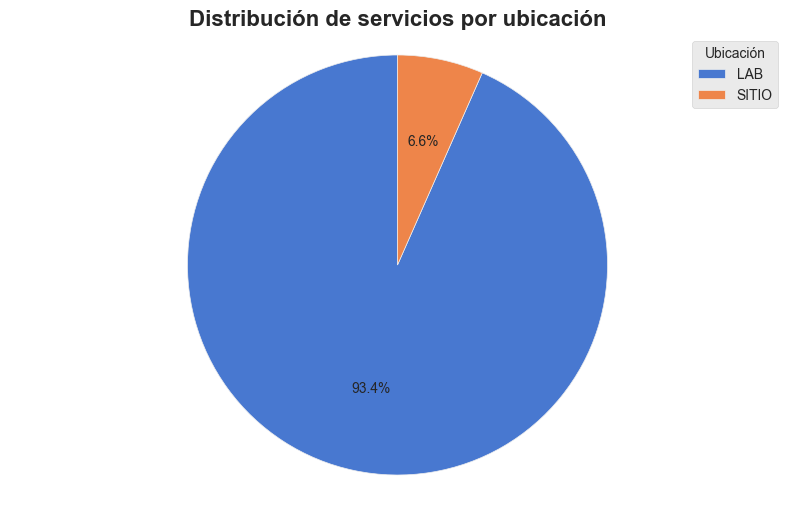

In [ ]:
# Verificamos los valores de la columna 'service_location' para analizar los servicios realizados por ubicaci√≥n
cal_location = mass_sin_errores.groupby(['service_location'])['report_number'].count().sort_values(ascending=False).reset_index()
#cal_location
# Crear figura
plt.figure(figsize=(10, 6))
#sns.set_palette("muted")

labels = cal_location['service_location'].tolist()
sizes = cal_location['report_number'].tolist()

# Crear gr√°fico de barras
plt.pie(sizes, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("muted", len(labels)))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribuci√≥n de servicios por ubicaci√≥n', fontsize=16, fontweight='bold')
plt.legend(labels, title='Ubicaci√≥n', loc='upper right', fontsize=10)
plt.show()

In [ ]:
loc_sitio  = mass_sin_errores[mass_sin_errores['service_location'] == 'SITIO']
loc_sitio = loc_sitio.drop(columns=['service_location'], errors='ignore')
loc_sitio.head(10)

report_number     so                  assignee  \
44   CCM0040.M/2025  H2461  Francisco Torres Cabrera   
72   CCM0062.M/2025  H2506  Francisco Torres Cabrera   
73   CCM0063.M/2025  H2506  Francisco Torres Cabrera   
116  CCM0104.M/2025  I0052    Guillermo Guzm√°n L√≥pez   
117  CCM0105.M/2025  I0052    Guillermo Guzm√°n L√≥pez   
119  CCM0107.M/2025  I0054     Mario de Jes√∫s Garc√≠a   
169  CCM0155.M/2025  I0139  Francisco Torres Cabrera   
176  CCM0162.M/2025  I0169  Francisco Torres Cabrera   
177  CCM0163.M/2025  I0169  Francisco Torres Cabrera   
210  CCM0195.M/2025  I0224  Francisco Torres Cabrera   

                   calibrator                supervisor  \
44   Francisco Torres Cabrera  Gabriel Gallardo Camacho   
72   Francisco Torres Cabrera  Gabriel Gallardo Camacho   
73   Francisco Torres Cabrera  Gabriel Gallardo Camacho   
116    Guillermo Guzm√°n L√≥pez  Francisco Torres Cabrera   
117    Guillermo Guzm√°n L√≥pez  Francisco Torres Cabrera   
119     Mario de Jes√∫s Garc√≠a  Gabriel Gallardo Camacho   
169  Francisco Torres Cabrera  Gabriel Gallardo Camacho   
176  Francisco Torres Cabrera  Gabriel Gallardo Camacho   
177  Francisco Torres Cabrera  Gabriel Gallardo Camacho   
210  Francisco Torres Cabrera  Gabriel Gallardo Camacho   

                     approver classification lab_received_date  \
44   Gabriel Gallardo Camacho             II        2024-12-17   
72   Gabriel Gallardo Camacho             II        2025-01-27   
73   Gabriel Gallardo Camacho              I        2025-01-27   
116  Francisco Torres Cabrera             II        2025-01-15   
117  Francisco Torres Cabrera              I        2025-01-15   
119  Gabriel Gallardo Camacho              I        2025-01-15   
169  Gabriel Gallardo Camacho            III        2025-02-17   
176  Gabriel Gallardo Camacho             II        2025-02-04   
177  Gabriel Gallardo Camacho             II        2025-02-04   
210  Gabriel Gallardo Camacho             II        2025-02-12   

    scheduled_delivery_date cleaning_date calibration_date delivery_date   \
44               2025-01-17    2025-01-14       2025-01-14     2025-01-15   
72               2025-02-14    2025-02-11       2025-02-11     2025-02-12   
73               2025-02-14    2025-02-11       2025-02-11     2025-02-12   
116                     NaT    2025-01-29       2025-01-29     2025-02-04   
117                     NaT    2025-01-29       2025-01-29     2025-02-04   
119                     NaT    2025-01-23       2025-01-23     2025-01-23   
169              2025-02-19    2025-02-14       2025-02-14     2025-02-17   
176              2025-03-20    2025-03-14       2025-03-14     2025-03-18   
177              2025-03-20    2025-03-14       2025-03-14     2025-03-18   
210              2025-02-28    2025-02-25       2025-02-25     2025-02-25   

     delivery_time  assigned_time   priority  piece_count equipment_type  
44             1.0            3.0  ORDINARIO          1.0        Balanza  
72             1.0            3.0  ORDINARIO          1.0        Balanza  
73             1.0            3.0  ORDINARIO          1.0        Balanza  
116            3.0            0.0  ORDINARIO          1.0        Balanza  
117            3.0            0.0  ORDINARIO          1.0        Balanza  
119            0.0            0.0  ORDINARIO          1.0        Balanza  
169            1.0            3.0  ORDINARIO          1.0        Balanza  
176            1.0            3.0  ORDINARIO          1.0        Balanza  
177            1.0            3.0  ORDINARIO          1.0        Balanza  
210            0.0            3.0  ORDINARIO          1.0        Balanza

In [ ]:
class_per_sitio = loc_sitio.groupby(['classification']).agg(
    rep_qty=('report_number', 'count'),
    deliv_time_avg=('delivery_time', 'mean')
).reset_index()
class_per_sitio = class_per_sitio.sort_values('rep_qty', ascending=False).round(2)
class_per_sitio

classification  rep_qty  deliv_time_avg
1             II       11            1.73
0              I        8            2.12
2            III        5            1.20

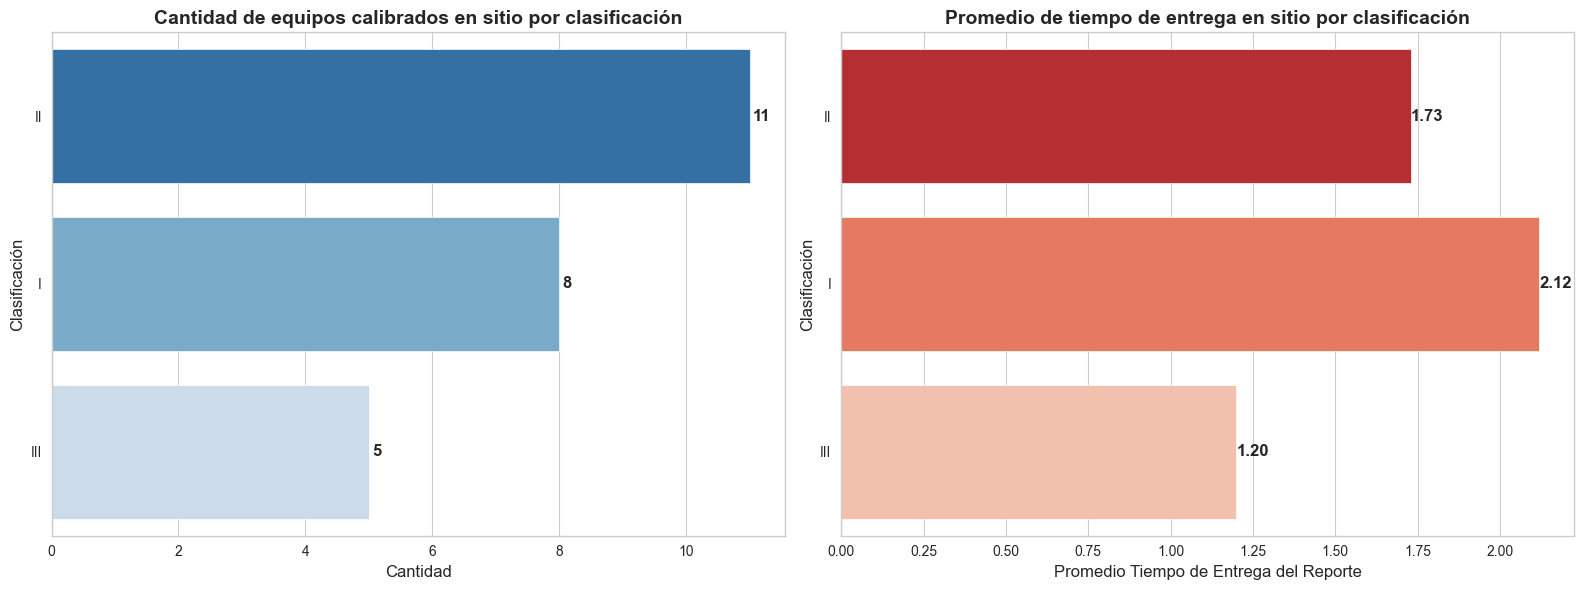

In [ ]:
# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Primer gr√°fico: Cantidad de equipos por clasificaci√≥n ---
sns.barplot(data=class_per_sitio, x='rep_qty', y='classification', hue='classification', palette='Blues_r', errorbar=None, legend=False, ax=axes[0])
axes[0].set_xlabel('Cantidad', fontsize=12)
axes[0].set_ylabel('Clasificaci√≥n', fontsize=12)
axes[0].set_title('Cantidad de equipos calibrados en sitio por clasificaci√≥n', fontsize=14, fontweight='bold')

# Agregar etiquetas en las barras del primer gr√°fico
for i, v in enumerate(class_per_sitio['rep_qty']):
    axes[0].text(v + 0.05, i, str(v), va='center', fontsize=12, fontweight='bold')

# --- Segundo gr√°fico: Promedio de tiempo de entrega por clasificaci√≥n ---
sns.barplot(data=class_per_sitio, x='deliv_time_avg', y='classification', hue='classification', palette='Reds_r', errorbar=None, legend=False, ax=axes[1])
axes[1].set_xlabel('Promedio Tiempo de Entrega del Reporte', fontsize=12)
axes[1].set_ylabel('Clasificaci√≥n', fontsize=12)  # Evitar la etiqueta duplicada del eje y
axes[1].set_title('Promedio de tiempo de entrega en sitio por clasificaci√≥n', fontsize=14, fontweight='bold')
#axes[1].tick_params(axis='y', left=False, labelleft=False) # Ocultar etiquetas del eje y duplicadas

# Agregar etiquetas en las barras del segundo gr√°fico
for i, v in enumerate(class_per_sitio['deliv_time_avg']):
    axes[1].text(v, i, f'{v:.2f}', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## An√°lisis de Entrega de Certificados por Clasificaci√≥n ‚Äì Servicios en Sitio

Dado que la calibraci√≥n se realiza en un d√≠a, las diferencias en tiempos de entrega se deben al proceso de **certificaci√≥n**. Las principales implicaciones son:

- **Clasificaci√≥n "I" (2.12 d√≠as)**  y **8 servicios**: Tiempo de entrega m√°s alto. Se deben revisar posibles ineficiencias en la generaci√≥n, revisi√≥n o entrega de certificados.
  
- **Clasificaci√≥n "III" (1.20 d√≠as)** y **11 servicios:** Entrega m√°s r√°pida. Podr√≠a servir como modelo para otras clasificaciones.

- **Clasificaci√≥n "II" (1.73 d√≠as)** y **5 servicvios:** Tiempo moderado. Es eficiente.

- **Enfoque en el flujo de certificados:** La calibraci√≥n no es el problema. Se deben detectar cuellos de botella en la documentaci√≥n y entrega.

- **Oportunidad de estandarizaci√≥n:** Adaptar las mejores pr√°cticas de la clasificaci√≥n "III" podr√≠a beneficiar a "I" y "II".

- **Revisi√≥n de recursos:** Posible necesidad de reforzar personal o herramientas para la clasificaci√≥n "I" o tener en cuenta el posible impacto en el tiempo de otros servicios asignados al mismo metr√≥logo.

**Conclusi√≥n:** Optimizar el proceso de certificaci√≥n, especialmente en "I", es clave para reducir tiempos de entrega y minimizar su influencia en los tiempos de otros servicios.


### Se comparan los tiempos de entrega de los certificados por clasificaci√≥n y por fechas de entrega de los certificados para ver si existe alguna relaci√≥n con los tiempos de entrega de los mismos

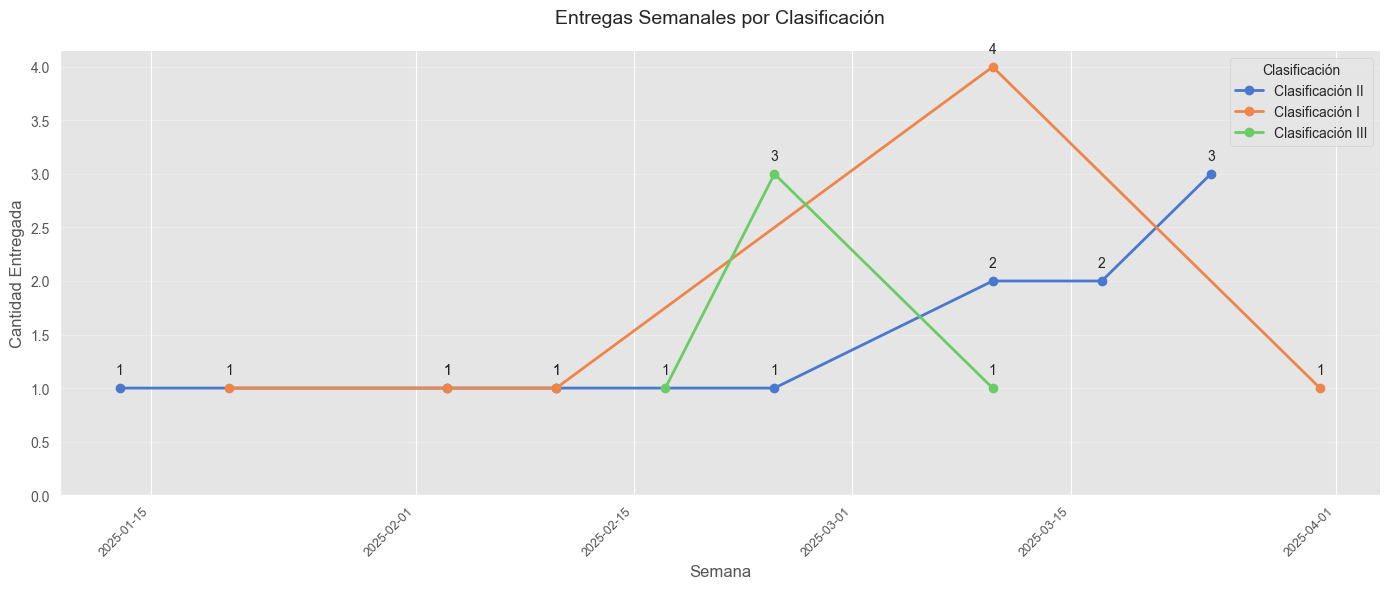

In [ ]:
# Copiar y limpiar el dataframe
df = loc_sitio.copy()
df.rename(columns={'delivery_date ': 'delivery_date'}, inplace=True)  # eliminar espacio
#df['delivery_date'] = pd.to_datetime(df['delivery_date '.strip()])  # eliminar espacio
df['week_start'] = df['delivery_date'].dt.to_period('W').dt.start_time

# Agrupar entregas por semana y clasificaci√≥n
weekly_counts = df.groupby(['week_start', 'classification']).size().reset_index(name='cantidad')

# Gr√°fico
plt.figure(figsize=(14, 6))

for clas in weekly_counts['classification'].unique():
    subset = weekly_counts[weekly_counts['classification'] == clas]
    
    # L√≠nea por clasificaci√≥n
    plt.plot(subset['week_start'], 
             subset['cantidad'], 
             marker='o', 
             linewidth=2, 
             label=f'Clasificaci√≥n {clas}')
    
    # Etiquetas por punto
    for i, row in subset.iterrows():
        plt.text(row['week_start'], row['cantidad'] + 0.1, str(row['cantidad']),
                 ha='center', va='bottom', fontsize=10)

# Est√©tica
plt.title('Entregas Semanales por Clasificaci√≥n', fontsize=14, pad=20)
plt.xlabel('Semana')
plt.ylabel('Cantidad Entregada')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.ylim(bottom=0)
plt.legend(title='Clasificaci√≥n')
sns.despine()
plt.tight_layout()
plt.show()

## An√°lisis de Entrega de Certificados por Clasificaci√≥n ‚Äì Servicios en Sitio a lo largo del tiempo

Los principales hallazgos son:

- **Primera quincena de marzo:** Hubo la mayor cantidad de servicios (7), por lo que seguramente tuvo influencia en los tiempos de entrega. 
  
- **Clasificaci√≥n "I" (4 servicios en una misma quincena):** Unido a otros 2 servicios en balanzas del **tipo I* y 1 balanza del tipo III, por lo que tuvo gran influencia en el tiempo de entrega en las balanzas del tipo I.  

- **Semanas cr√≠ticas:** La primera quincena de marzo requiere asignaci√≥n prioritaria de recursos para evitar retrasos recurrentes, tanto en servicios en sitio como en el laboratorio.

## Analicemos ahora los servicios de calibraci√≥n en el laboratorio

In [ ]:
loc_lab  = mass_sin_errores[mass_sin_errores['service_location'] == 'LAB']
loc_lab = loc_lab.drop(columns=['service_location'], errors='ignore')
loc_lab.head(10)

report_number     so                            assignee  \
0     CCM0001.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
1     CCM0002.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
2     CCM0003.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
3     CCM0004.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
4  CCM0005.M/2025 v0  I0082  Leobardo Maximiliano Brito Fonseca   
5  CCM0005.M/2025 v1  H2381  Leobardo Maximiliano Brito Fonseca   
6     CCM0006.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
7     CCM0007.M/2025  H2395            Francisco Torres Cabrera   
8     CCM0008.M/2025  H2403              Guillermo Guzm√°n L√≥pez   
9     CCM0009.M/2025  H2403              Guillermo Guzm√°n L√≥pez   

                           calibrator                          supervisor  \
0  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
1  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
2  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
3  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
4  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
5  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
6  Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
7            Francisco Torres Cabrera  Leobardo Maximiliano Brito Fonseca   
8              Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   
9              Guillermo Guzm√°n L√≥pez  Leobardo Maximiliano Brito Fonseca   

                             approver classification lab_received_date  \
0            Gabriel Gallardo Camacho             E2        2024-12-05   
1            Gabriel Gallardo Camacho             E2        2024-12-05   
2            Gabriel Gallardo Camacho             E2        2024-12-05   
3            Gabriel Gallardo Camacho             E2        2024-12-05   
4            Gabriel Gallardo Camacho             E2        2025-01-21   
5            Gabriel Gallardo Camacho             E2        2024-12-05   
6            Gabriel Gallardo Camacho             E2        2024-12-05   
7  Leobardo Maximiliano Brito Fonseca             E2        2024-12-06   
8  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   
9  Leobardo Maximiliano Brito Fonseca             M1        2024-12-09   

  scheduled_delivery_date cleaning_date calibration_date delivery_date   \
0              2025-01-06    2024-12-06       2025-01-10     2025-01-10   
1              2025-01-06    2024-12-06       2025-01-10     2025-01-10   
2              2025-01-06    2024-12-06       2025-01-10     2025-01-10   
3              2025-01-06    2024-12-06       2025-01-10     2025-01-10   
4              2025-01-31    2025-01-21       2025-01-30     2025-01-30   
5              2025-01-06    2024-12-06       2025-01-10     2025-01-10   
6              2025-01-06    2024-12-06       2025-01-10     2025-01-10   
7              2025-01-08    2024-12-06       2025-01-07     2025-01-07   
8              2025-01-06    2025-01-02       2025-01-06     2025-01-06   
9              2025-01-06    2025-01-02       2025-01-06     2025-01-06   

   delivery_time  assigned_time   priority  piece_count equipment_type  
0           24.0           20.0  ORDINARIO          1.0           Pesa  
1           24.0           20.0  ORDINARIO          1.0           Pesa  
2           24.0           20.0  ORDINARIO          1.0           Pesa  
3           24.0           20.0  ORDINARIO          1.0           Pesa  
4            7.0            8.0  ORDINARIO          1.0           Pesa  
5           24.0           20.0  ORDINARIO          1.0           Pesa  
6           24.0           20.0  ORDINARIO          1.0           Pesa  
7           20.0           21.0  ORDINARIO         22.0           Pesa  
8           18.0           18.0  ORDINARIO          4.0           Pesa  
9           18.0           18.0  ORDINARIO

In [ ]:
loc_lab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 0 to 385
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            339 non-null    object        
 1   so                       339 non-null    object        
 2   assignee                 339 non-null    object        
 3   calibrator               339 non-null    object        
 4   supervisor               339 non-null    object        
 5   approver                 339 non-null    object        
 6   classification           339 non-null    object        
 7   lab_received_date        339 non-null    datetime64[ns]
 8   scheduled_delivery_date  339 non-null    datetime64[ns]
 9   cleaning_date            335 non-null    datetime64[ns]
 10  calibration_date         339 non-null    datetime64[ns]
 11  delivery_date            339 non-null    datetime64[ns]
 12  delivery_time            339 non-null    

In [ ]:
# Verificamos los valores nulos de las columnas con valores faltantes en la tabla

resultado = pysqldf("""
    SELECT report_number, cleaning_date
    FROM loc_lab
    WHERE scheduled_delivery_date IS NULL or cleaning_date IS NULL """)

resultado

report_number cleaning_date
0  CCM0091.M/2025          None
1  CCM0184.M/2025          None
2  CCM0268.M/2025          None
3  CCM0269.M/2025          None

**Los valores faltantes son consistentes con los datos y por tanto se mantienen de esa forma.**

##### Buscamos si quedaron algunos valores duplicados

In [ ]:
no_dup = loc_lab[loc_lab.duplicated(keep=False)]
no_dup

Empty DataFrame
Columns: [report_number, so, assignee, calibrator, supervisor, approver, classification, lab_received_date, scheduled_delivery_date, cleaning_date, calibration_date, delivery_date , delivery_time, assigned_time, priority, piece_count, equipment_type]
Index: []

#### No hay elementos duplicados en la tabla, por lo que no es necesario eliminar duplicados

### An√°lisis de la cantidad de reportes y piezas por clasificaci√≥n de equipo

In [ ]:
qty_per_class = loc_lab.groupby(['classification']).agg(
    rep_qty=('report_number', 'count'),
    qty_pieces=('piece_count', 'sum'),
    deliv_time_avg=('delivery_time', 'mean')
).reset_index()
qty_per_class = qty_per_class.sort_values('rep_qty', ascending=False).round(2)
qty_per_class

classification  rep_qty  qty_pieces  deliv_time_avg
4             E2      142       771.0           11.63
5             F1      108       641.0            8.80
7             M1       53       332.0            8.49
6             F2       21       143.0            9.05
0              1        4        32.0           12.50
1              2        4         4.0           14.00
3             E1        3        51.0           37.33
8             M2        3         8.0            9.67
2              6        1         2.0            5.00

In [ ]:
totales = qty_per_class[['rep_qty', 'qty_pieces']].sum()
totales

rep_qty        339.0
qty_pieces    1984.0
dtype: float64

<Figure size 1000x700 with 0 Axes>

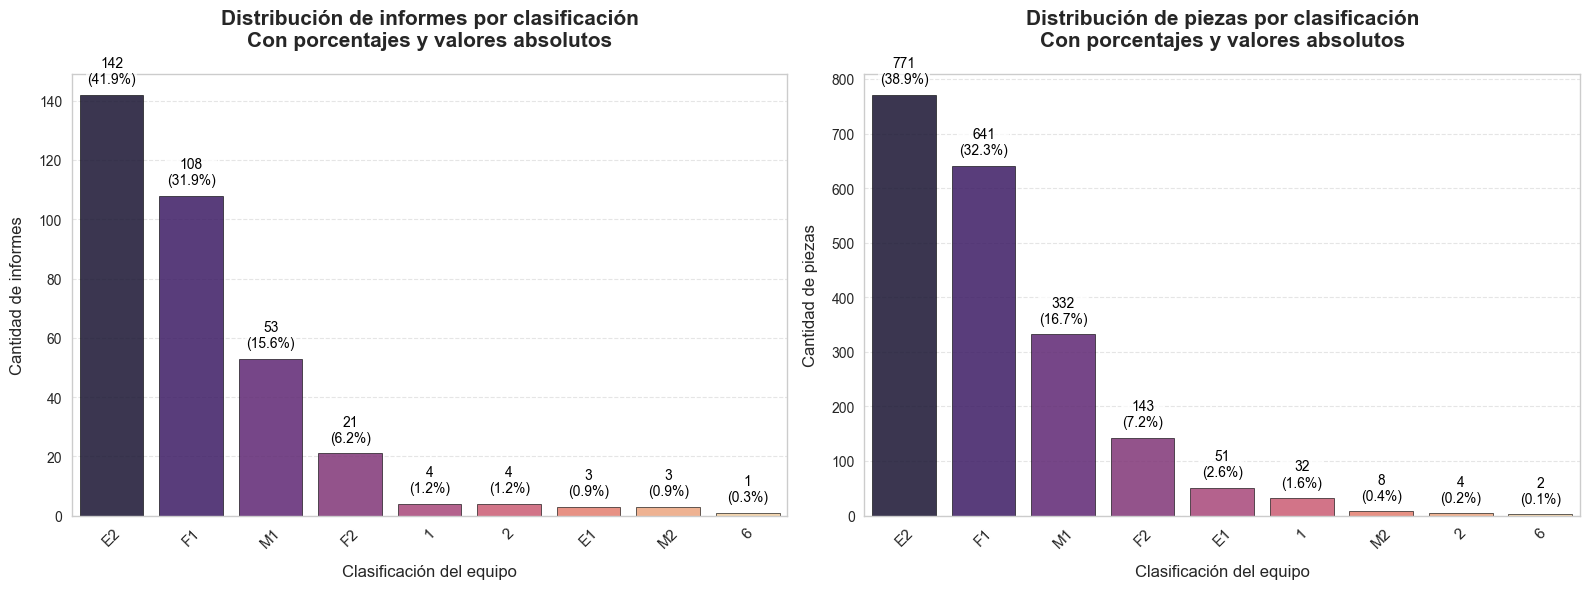

In [ ]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Primer gr√°fico: Cantidad de informes por clasificaci√≥n ---
# Calculamos los porcentajes
total = qty_per_class['rep_qty'].sum()
qty_per_class['percentage'] = (qty_per_class['rep_qty'] / total) * 100

sns.barplot(
    x='classification',
    y='rep_qty',
    hue='classification',  # Added to address warning
    data=qty_per_class,
    palette='magma',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
    dodge=False,  # Prevents side-by-side bars when using hue
    legend=False,
    ax=axes[0]  # Hides redundant legend
)

# A√±adir etiquetas con valores absolutos y porcentajes
for i, bar in enumerate(axes[0].patches):
    height = bar.get_height()
    percentage = qty_per_class['percentage'].iloc[i]
    
    axes[0].text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height + (0.02 * max(qty_per_class['rep_qty'])),  # Offset din√°mico
        s=f"{height:.0f}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Mejorar el t√≠tulo y etiquetas
axes[0].set_title("Distribuci√≥n de informes por clasificaci√≥n\nCon porcentajes y valores absolutos", 
                  fontsize=15, pad=20, fontweight='bold')
axes[0].set_xlabel("Clasificaci√≥n del equipo", fontsize=12, labelpad=10)
axes[0].set_ylabel("Cantidad de informes", fontsize=12, labelpad=10)

# Rotaci√≥n y formato de ejes
axes[0].tick_params(axis='x', rotation=45, labelsize=11)
axes[0].tick_params(axis='y', labelsize=10)

# Cuadr√≠cula
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Segundo gr√°fico: Cantidad de piezas por clasificaci√≥n ---
# Calculamos los porcentajes
total = qty_per_class['qty_pieces'].sum()
qty_per_class['percentage'] = (qty_per_class['qty_pieces'] / total) * 100

# Ordenar el DataFrame por 'qty_pieces' de forma descendente
qty_per_class_ordenado = qty_per_class.sort_values(by='qty_pieces', ascending=False)

sns.barplot(
    x='classification',
    y='qty_pieces',
    hue='classification',  # Added to address warning
    data=qty_per_class_ordenado,  # Usar el DataFrame ordenado
    palette='magma',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
    dodge=False,  # Prevents side-by-side bars when using hue
    legend=False,
    ax=axes[1]  # Hides redundant legend
)

# A√±adir etiquetas con valores absolutos y porcentajes
for i, bar in enumerate(axes[1].patches):
    height = bar.get_height()
    percentage = qty_per_class_ordenado['percentage'].iloc[i]  # Usar el DataFrame ordenado

    axes[1].text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height + (0.02 * max(qty_per_class_ordenado['qty_pieces'])),  # Offset din√°mico
        s=f"{height:.0f}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Mejorar el t√≠tulo y etiquetas
axes[1].set_title("Distribuci√≥n de piezas por clasificaci√≥n\nCon porcentajes y valores absolutos",
                    fontsize=15, pad=20, fontweight='bold')
axes[1].set_xlabel("Clasificaci√≥n del equipo", fontsize=12, labelpad=10)
axes[1].set_ylabel("Cantidad de piezas", fontsize=12, labelpad=10)

# Rotaci√≥n y formato de ejes
axes[1].tick_params(axis='x', rotation=45, labelsize=11)
axes[1].tick_params(axis='y', labelsize=10)

# Cuadr√≠cula
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Ajustar m√°rgenes
plt.tight_layout()
plt.show()


### Distribuci√≥n de Informes y Cantidad de Piezas por Clasificaci√≥n  


### üîç Hallazgos Clave  
1. **Dominancia clara**:  
   - La clasificaci√≥n **E2** concentra el **41.9% del total de informes** (339 informes) y el **38.9% de las piezas** (1984 piezas).  
   - Las categor√≠as (E2, F1, M1 Y F2) representan **95.6%** del total de informes (339 informes) y el **95.1%** de las piezas (1984 piezas). 

2. **Cola larga**:  
   - 5 clasificaciones (1, 2, E1, M2 y 6) con ‚â§ 5.0% de participaci√≥n en total de informes y de piezas.
   - La clasificaci√≥n **E1** tiene un n√∫mero significativo de piezas (2.6% del total), pero solo representa el **0.9% de los informes**, lo que sugiere que cada informe involucra un n√∫mero elevado de piezas.

## An√°lisis de los tiempos de entrega por clasificaci√≥n de equipo

In [ ]:
class_del_time = qty_per_class[['classification','rep_qty', 'qty_pieces', 'deliv_time_avg']].sort_values(by='deliv_time_avg', ascending=False).reset_index(drop=True)
class_del_time['pieces_per_report'] = class_del_time['qty_pieces'] / class_del_time['rep_qty']
class_del_time['pieces_per_report'] = class_del_time['pieces_per_report'].round(2)
class_del_time

classification  rep_qty  qty_pieces  deliv_time_avg  pieces_per_report
0             E1        3        51.0           37.33              17.00
1              2        4         4.0           14.00               1.00
2              1        4        32.0           12.50               8.00
3             E2      142       771.0           11.63               5.43
4             M2        3         8.0            9.67               2.67
5             F2       21       143.0            9.05               6.81
6             F1      108       641.0            8.80               5.94
7             M1       53       332.0            8.49               6.26
8              6        1         2.0            5.00               2.00

class_del_time = mass_sin_errores.groupby(['classification'])['delivery_time'].mean().round(2).reset_index()
class_del_time

C:\Users\Miguel Oscar\AppData\Local\Temp\ipykernel_23940\3614716414.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


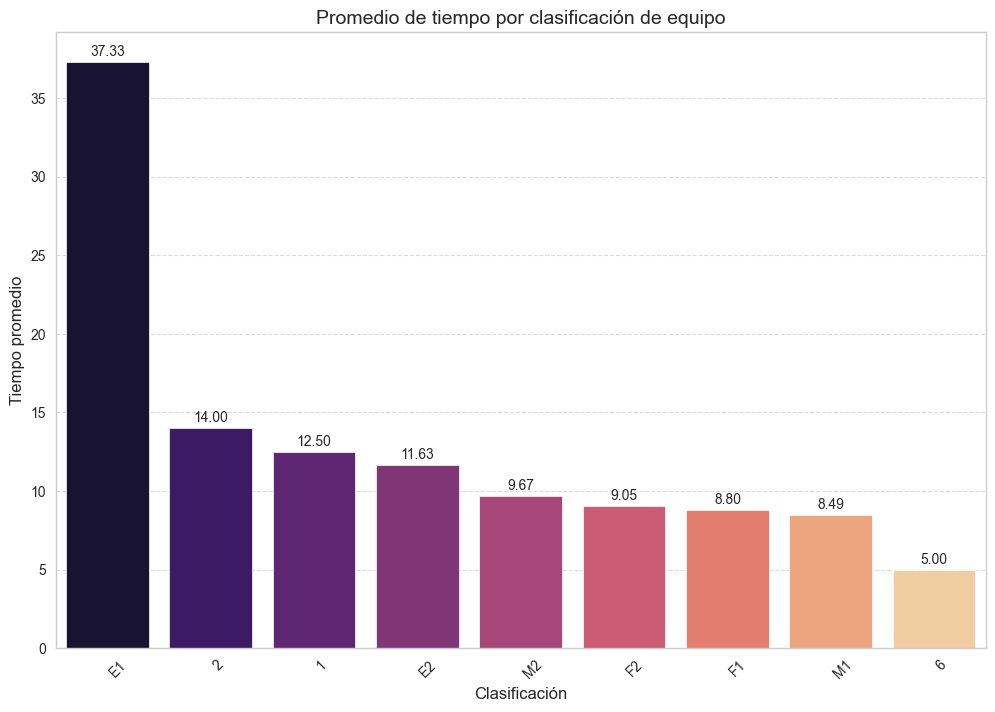

In [ ]:

plt.figure(figsize=(12, 8))
# Sintaxis b√°sica
ax = sns.barplot(
    x='classification',  # Variable categ√≥rica (eje x)
    y='deliv_time_avg',   # Variable num√©rica (eje y)
    data=class_del_time,
    #estimator='mean',  # Funci√≥n de agregaci√≥n (mean, sum, median, etc.)
    palette='magma',            # Intervalo de confianza (o 'sd' para desviaci√≥n est√°ndar)
    #color='blue'       # Color de las barras
)

# A√±adir los valores en las barras
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Posici√≥n horizontal centrada
        y=height + 0.2,                       # Posici√≥n vertical (altura + offset)
        s=f"{height:.2f}",                    # Texto (2 decimales)
        ha="center",                           # Alineaci√≥n horizontal
        va="bottom",                           # Alineaci√≥n vertical
        fontsize=10
    )

plt.title("Promedio de tiempo por clasificaci√≥n de equipo", fontsize=14)
plt.xlabel("Clasificaci√≥n", fontsize=12)
plt.ylabel("Tiempo promedio", fontsize=12)
plt.xticks(rotation=45, ha='left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Solo l√≠neas de cuadr√≠cula en el eje y

plt.show()

# An√°lisis de Casos At√≠picos y Recomendaciones

## üî¥ Casos At√≠picos Identificados

### 1. Demora Extrema en Calibraci√≥n (37.33 d√≠as)
- **Descripci√≥n**:  
  Tiempo de calibraci√≥n 7.5 veces mayor que el valor m√°s bajo (5 d√≠as)
- **Impacto**:  
  Puede retrasar toda la cadena de procesos del laboratorio

## üõ† Recomendaciones Espec√≠ficas

### Para Demora de 37.33 D√≠as
1. **Acci√≥n Inmediata**:  
    - Revisar el caso espec√≠fico para entender la causa de la demora.
    - Considerar la posibilidad de un mapeo del proceso que permita identificar los cuellos de botella.
    - Analizar si el tiempo de entrega se vio afectado por la cantidad de piezas enviadas o por la complejidad del equipo.
2. **Revisi√≥n del proceso**:
    - Evaluar si el tiempo de entrega asignado es adecuado para este tipo de calibraci√≥n.
    - Considerar la posibilidad de ajustar los tiempos asignados para evitar demoras excesivas en el futuro.
3. **Documentaci√≥n**:
    - Registrar el caso y las acciones tomadas para futuras referencias.
    - Utilizar esta informaci√≥n para mejorar los procesos y evitar demoras similares en el futuro.
4. **An√°lisis de datos**:
    - Realizar un an√°lisis de datos para identificar patrones o tendencias en los tiempos de entrega.
    - Utilizar esta informaci√≥n para mejorar la planificaci√≥n y la gesti√≥n de recursos en el laboratorio.

### --------------------------------------------------------------------------------------------------

## An√°lisis de los tiempos de entrega vs los tiempos asignados

In [ ]:
tiempo = loc_lab.groupby(['classification']).agg(
    rep_qty=('report_number', 'count'),
    qty_pieces=('piece_count', 'sum'),
    deliv_time_avg=('delivery_time', 'mean'),
    assigned_time_avg=('assigned_time', 'mean'),
    pieces_per_report=('piece_count', lambda x: x.sum() / len(x)),
).reset_index()
tiempo = tiempo.sort_values('rep_qty', ascending=False).round(2)
tiempo

classification  rep_qty  qty_pieces  deliv_time_avg  assigned_time_avg  \
4             E2      142       771.0           11.63              15.58   
5             F1      108       641.0            8.80              12.60   
7             M1       53       332.0            8.49              12.30   
6             F2       21       143.0            9.05              12.90   
0              1        4        32.0           12.50              15.50   
1              2        4         4.0           14.00              18.00   
3             E1        3        51.0           37.33              30.00   
8             M2        3         8.0            9.67              14.00   
2              6        1         2.0            5.00              12.00   

   pieces_per_report  
4               5.43  
5               5.94  
7               6.26  
6               6.81  
0               8.00  
1               1.00  
3              17.00  
8               2.67  
2               2.00

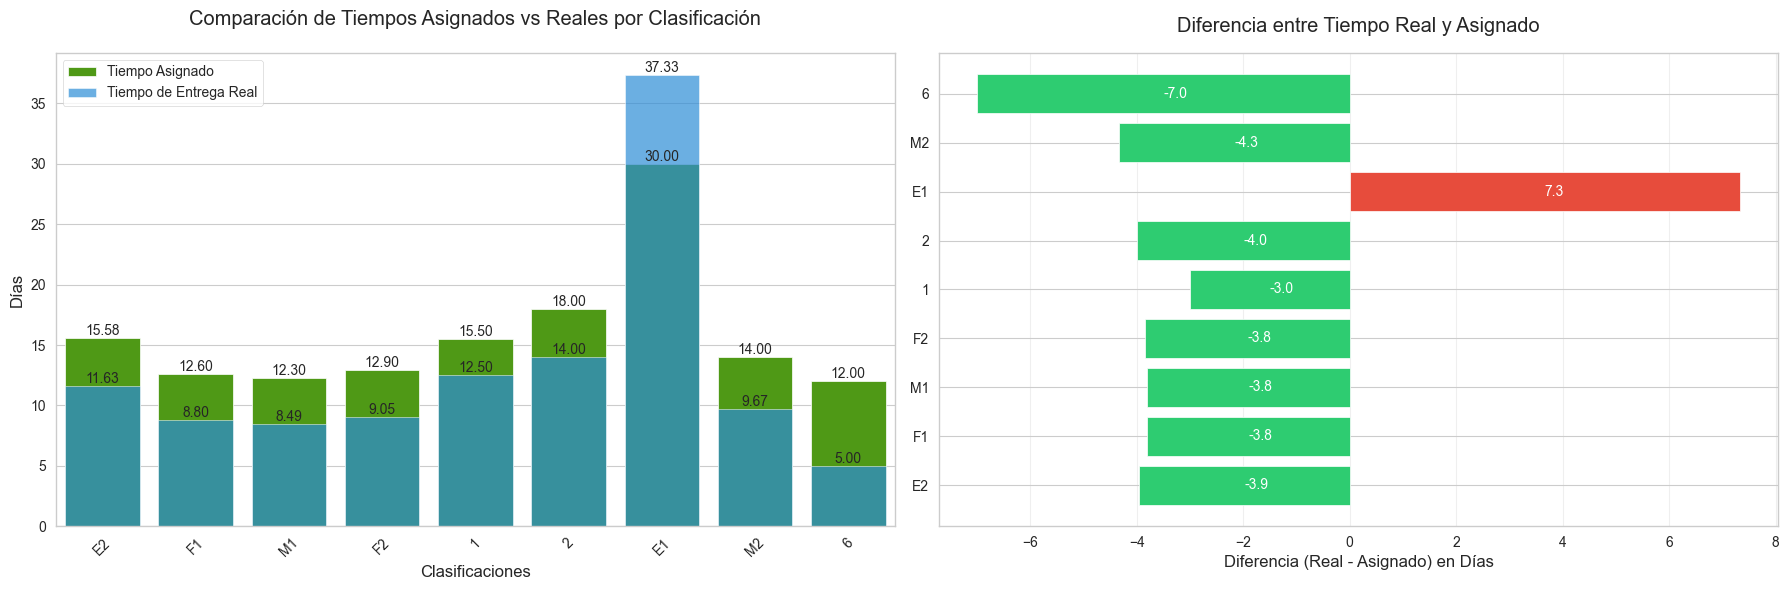

In [ ]:
equipos = tiempo['classification'].tolist()
asignado = tiempo['assigned_time_avg'].tolist()
real = tiempo['deliv_time_avg'].tolist()
diferencias = [r - a for r, a in zip(real, asignado)]

# Configurar la figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Primer Gr√°fico: Comparaci√≥n de Tiempos Asignados vs Reales ---
ax1 = axes[0]
sns.barplot(x=equipos, y=asignado, color='#4CAF00', label='Tiempo Asignado', ax=ax1)
sns.barplot(x=equipos, y=real, color='#1191F3', label='Tiempo de Entrega Real', alpha=0.7, ax=ax1)

# Personalizaci√≥n del primer gr√°fico
ax1.set_title('Comparaci√≥n de Tiempos Asignados vs Reales por Clasificaci√≥n', pad=20)
ax1.set_xlabel('Clasificaciones')
ax1.set_ylabel('D√≠as')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# A√±adir valores al primer gr√°fico
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

# --- Segundo Gr√°fico: Diferencia entre Tiempo Real y Asignado ---
ax2 = axes[1]
bars = ax2.barh(equipos, diferencias, color=np.where(np.array(diferencias) > 0, '#e74c3c', '#2ecc71'))

# Personalizaci√≥n del segundo gr√°fico
ax2.set_title('Diferencia entre Tiempo Real y Asignado', pad=15)
ax2.set_xlabel('Diferencia (Real - Asignado) en D√≠as')
ax2.grid(axis='x', alpha=0.3)

# A√±adir valores al segundo gr√°fico
for bar in bars:
    width = bar.get_width()
    ax2.text(width/2, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}',
             va='center',
             color='white' if abs(width) > 1 else 'black')

plt.tight_layout()
plt.show()

## An√°lisis General

**1.üìä Sobrestimaci√≥n General:**  
En la mayor√≠a de las clasificaciones, el tiempo asignado parece ser una sobreestimaci√≥n del tiempo de entrega real. Esto podr√≠a indicar:
- Procesos operativos eficientes.
- Planificaci√≥n conservadora en la asignaci√≥n.
- Ajustar los tiempos asignados para reflejar mejor la realidad operativa.
- Oportunidad de optimizaci√≥n en la asignaci√≥n de tiempos.

**2.‚ö†Ô∏è Problema Cr√≠tico en la Clasificaci√≥n "2":**  
La clasificaci√≥n "2" presenta una desviaci√≥n alarmante:
- Tiempo real **excede significativamente** el asignado.
- Requiere investigaci√≥n inmediata para identificar:
  - Cuellos de botella operativos.
  - Errores en la estimaci√≥n inicial.

**3.üìä Variabilidad en la Precisi√≥n de la Estimaci√≥n:**  
- Magnitud de diferencias (real vs. asignado) var√≠a entre clasificaciones.
- Sugiere inconsistencias en los m√©todos de estimaci√≥n.

**4.üîç Potencial de Optimizaci√≥n:**  
- Tiempo real menor al asignado en la mayor√≠a de casos se√±ala oportunidades para:
  - Ajustar est√°ndares de planificaci√≥n.
  - Reducir m√°rgenes de seguridad excesivos.
  - Verificar el impacto de la cantidad de piezas en el tiempo de entrega.
  - Considerar la posibilidad de ajustar los tiempos asignados para evitar sobrecargas en el proceso de calibraci√≥n.

---

##üí° Puntos Clave para la Acci√≥n

1. **Prioridad Urgente: Clasificaci√≥n "2"**  
   - Realizar an√°lisis de causa ra√≠z (ej: diagrama de Ishikawa o de espina de pescado).
   - Evaluar recursos asignados vs. requerimientos reales.

2. **Analizar Diferencias Negativas Destacadas**  
   - Identificar pr√°cticas eficientes en clasificaciones con:
   - Diferencias negativas mayores a 2 d√≠as.
   - Replicar buenas pr√°cticas en otras √°reas.

3. **Revisi√≥n del Proceso de Estimaci√≥n**  
   - Revisar las metodolog√≠as actuales de asignaci√≥n de tiempos.
   - Implementar sistema de feedback continuo entre equipos operativos y de planificaci√≥n.

---

**Conclusi√≥n**  
El gr√°fico revela:  
‚ö†Ô∏è **Falla cr√≠tica en Clasificaci√≥n "2"** (tiempo de entrega excesivo)  
‚úÖ **Sobrestimaci√≥n sistem√°tica** en otras clasificaciones (oportunidad de optimizaci√≥n).  

*Acciones recomendadas:*  
- Correcci√≥n inmediata para Clasificaci√≥n "2".  
- Estandarizaci√≥n de procesos de estimaci√≥n con datos hist√≥ricos.  

# -------------------------------------------------------------------

In [ ]:
loc_lab

report_number     so                            assignee  \
0       CCM0001.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
1       CCM0002.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
2       CCM0003.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
3       CCM0004.M/2025  H2381  Leobardo Maximiliano Brito Fonseca   
4    CCM0005.M/2025 v0  I0082  Leobardo Maximiliano Brito Fonseca   
..                 ...    ...                                 ...   
381     CCM1842.M/2024  H2416               Mario de Jes√∫s Garc√≠a   
382     CCM1862.M/2024  H2428                Sergio Cruz Santiago   
383     CCM1863.M/2024  H2428                Sergio Cruz Santiago   
384     CCM1864.M/2024  H2428                Sergio Cruz Santiago   
385     CCM1865.M/2024  H2428                Sergio Cruz Santiago   

                             calibrator                          supervisor  \
0    Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
1    Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
2    Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
3    Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
4    Leobardo Maximiliano Brito Fonseca            Gabriel Gallardo Camacho   
..                                  ...                                 ...   
381               Mario de Jes√∫s Garc√≠a  Leobardo Maximiliano Brito Fonseca   
382                Sergio Cruz Santiago            Francisco Torres Cabrera   
383                Sergio Cruz Santiago            Francisco Torres Cabrera   
384                Sergio Cruz Santiago            Francisco Torres Cabrera   
385                Sergio Cruz Santiago            Francisco Torres Cabrera   

                               approver classification lab_received_date  \
0              Gabriel Gallardo Camacho             E2        2024-12-05   
1              Gabriel Gallardo Camacho             E2        2024-12-05   
2              Gabriel Gallardo Camacho             E2        2024-12-05   
3              Gabriel Gallardo Camacho             E2        2024-12-05   
4              Gabriel Gallardo Camacho             E2        2025-01-21   
..                                  ...            ...               ...   
381  Leobardo Maximiliano Brito Fonseca             M1        2024-12-10   
382            Francisco Torres Cabrera              2        2024-12-11   
383            Francisco Torres Cabrera              2        2024-12-11   
384            Francisco Torres Cabrera              2        2024-12-11   
385            Francisco Torres Cabrera              2        2024-12-11   

    scheduled_delivery_date cleaning_date calibration_date delivery_date   \
0                2025-01-06    2024-12-06       2025-01-10     2025-01-10   
1                2025-01-06    2024-12-06       2025-01-10     2025-01-10   
2                2025-01-06    2024-12-06       2025-01-10     2025-01-10   
3                2025-01-06    2024-12-06       2025-01-10     2025-01-10   
4                2025-01-31    2025-01-21       2025-01-30     2025-01-30   
..                      ...           ...              ...            ...   
381              2025-01-07    2024-12-17       2024-12-19     2025-01-07   
382              2025-01-08    2024-12-12       2024-12-20     2025-01-02   
383              2025-01-08    2024-12-12       2024-12-20     2025-01-02   
384              2025-01-08    2024-12-12       2024-12-20     2025-01-02   
385              2025-01-08    2024-12-12       2024-12-20     2025-01-02   

     delivery_time  assigned_time   priority  piece_count equipment_type  
0             24.0           20.0  ORDINARIO          1.0           Pesa  
1             24.0           20.0  ORDINARIO          1.0           Pesa  
2             24.0           20.0  ORDINARIO          1.0           Pesa  
3             24.0           20.0  ORDINARIO          1.0           Pesa  
4             

In [ ]:
loc_lab.columns

Index(['report_number', 'so', 'assignee', 'calibrator', 'supervisor',
       'approver', 'classification', 'lab_received_date',
       'scheduled_delivery_date', 'cleaning_date', 'calibration_date',
       'delivery_date ', 'delivery_time', 'assigned_time', 'priority',
       'piece_count', 'equipment_type'],
      dtype='object')

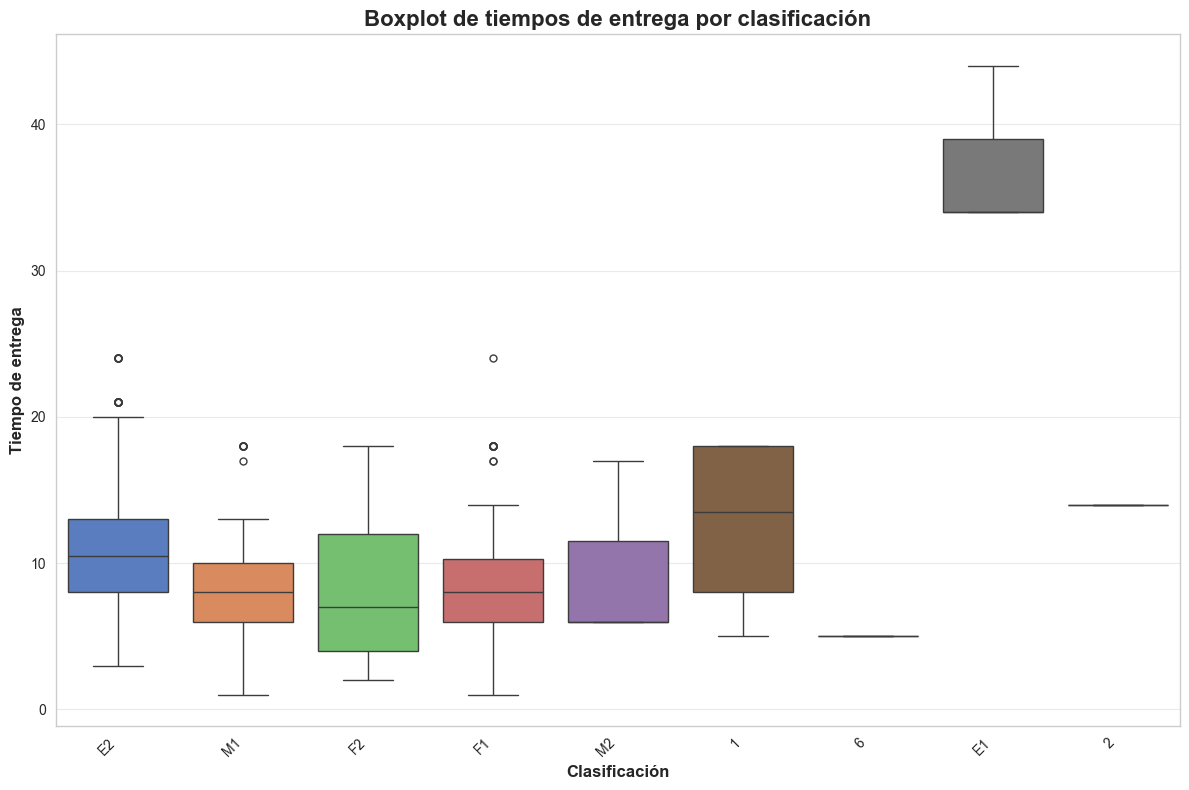

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
boxplot = sns.boxplot(x='classification', y='delivery_time', hue='classification', 
                      data=loc_lab, width=0.8, fliersize=5, whis=1.5, ax=ax)

# A√±adir etiquetas a los outliers
for i, artist in enumerate(boxplot.artists):
    # Obtener la clasificaci√≥n actual
    classification = loc_lab['classification'].unique()[i]
    
    # Obtener los datos para esta clasificaci√≥n
    category_data = loc_lab[loc_lab['classification'] == classification]['delivery_time']
    
    # Calcular Q1, Q3 e IQR
    Q1 = np.percentile(category_data, 25)
    Q3 = np.percentile(category_data, 75)
    IQR = Q3 - Q1
    
    # Identificar outliers
    outliers = category_data[(category_data < Q1 - 1.5 * IQR) | (category_data > Q3 + 1.5 * IQR)]
    
    # Para cada outlier, a√±adir una etiqueta
    for outlier_value in outliers:
        # Obtener el √≠ndice/fila del outlier
        outlier_index = loc_lab[(loc_lab['classification'] == classification) & 
                               (loc_lab['delivery_time'] == outlier_value)].index
        
        # Para cada √≠ndice encontrado (podr√≠a haber m√∫ltiples filas con el mismo valor)
        for idx in outlier_index:
            # Obtener la posici√≥n x (basada en la posici√≥n de la categor√≠a)
            x_pos = i
            
            # A√±adir etiqueta de texto
            ax.text(x_pos, outlier_value, f'{idx}', 
                    ha='center', va='bottom', fontsize=9, 
                    color='red', fontweight='bold')

# Personalizar el gr√°fico
plt.title('Boxplot de tiempos de entrega por clasificaci√≥n', fontsize=16, fontweight='bold')
plt.xlabel('Clasificaci√≥n', fontsize=12, fontweight='bold')
plt.ylabel('Tiempo de entrega', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()  # Ajustar dise√±o para evitar recortes
plt.show()

# An√°lisis: Boxplot de Tiempos de Entrega por Clasificaci√≥n

## Hallazgos principales

- **E1**: Tiempos de entrega significativamente superiores (33-39 d√≠as), con distribuci√≥n compacta que indica consistencia.

- **Clasificaciones est√°ndar** (E2, F1, F2, M1, M2, 1): Presentan medianas entre 7-13 d√≠as, formando un grupo homog√©neo con variaciones moderadas.

- **Outliers**: Detectados principalmente en E2, F1 y M1, con tiempos de entrega at√≠picos que llegan hasta ~24 d√≠as.

- **Casos especiales**: 
  - Clasificaci√≥n "6": Valor √∫nico o muy poca variaci√≥n (~5 d√≠as)
  - Clasificaci√≥n "2": Distribuci√≥n extremadamente compacta (~13 d√≠as)

## Variabilidad por clasificaci√≥n

| Clasificaci√≥n | Variabilidad | Mediana aproximada | Outliers |
|---------------|--------------|-------------------|----------|
| E1 | Baja | 35 d√≠as | No |
| 1 | Alta | 13 d√≠as | No |
| E2 | Media | 10 d√≠as | S√≠ (2) |
| F1 | Media | 8 d√≠as | S√≠ (3) |
| F2 | Alta | 7 d√≠as | No |
| M1 | Media | 8 d√≠as | S√≠ (2) |
| M2 | Media | 9 d√≠as | No |
| 6 | Muy baja | 5 d√≠as | No |
| 2 | Muy baja | 13 d√≠as | No |

## Implicaciones

1. **Segmentaci√≥n clara**: E1 constituye un grupo completamente separado, que requerir√≠a expectativas de entrega diferentes.

2. **Predictibilidad**: Las clasificaciones con baja variabilidad (E1, 6, 2) permiten estimaciones m√°s precisas de tiempos de entrega.

3. **Investigaci√≥n necesaria**: Los outliers identificados en varias clasificaciones sugieren incidentes espec√≠ficos que merecen an√°lisis para determinar causas de retrasos.

# ---------------------------------------------------------------------------

## Se comparan los tiempos de entrega promedios por clasificaci√≥n de equipo para ver si existe alguna relaci√≥n con la cantidad de piezas promedio por por cada clase.


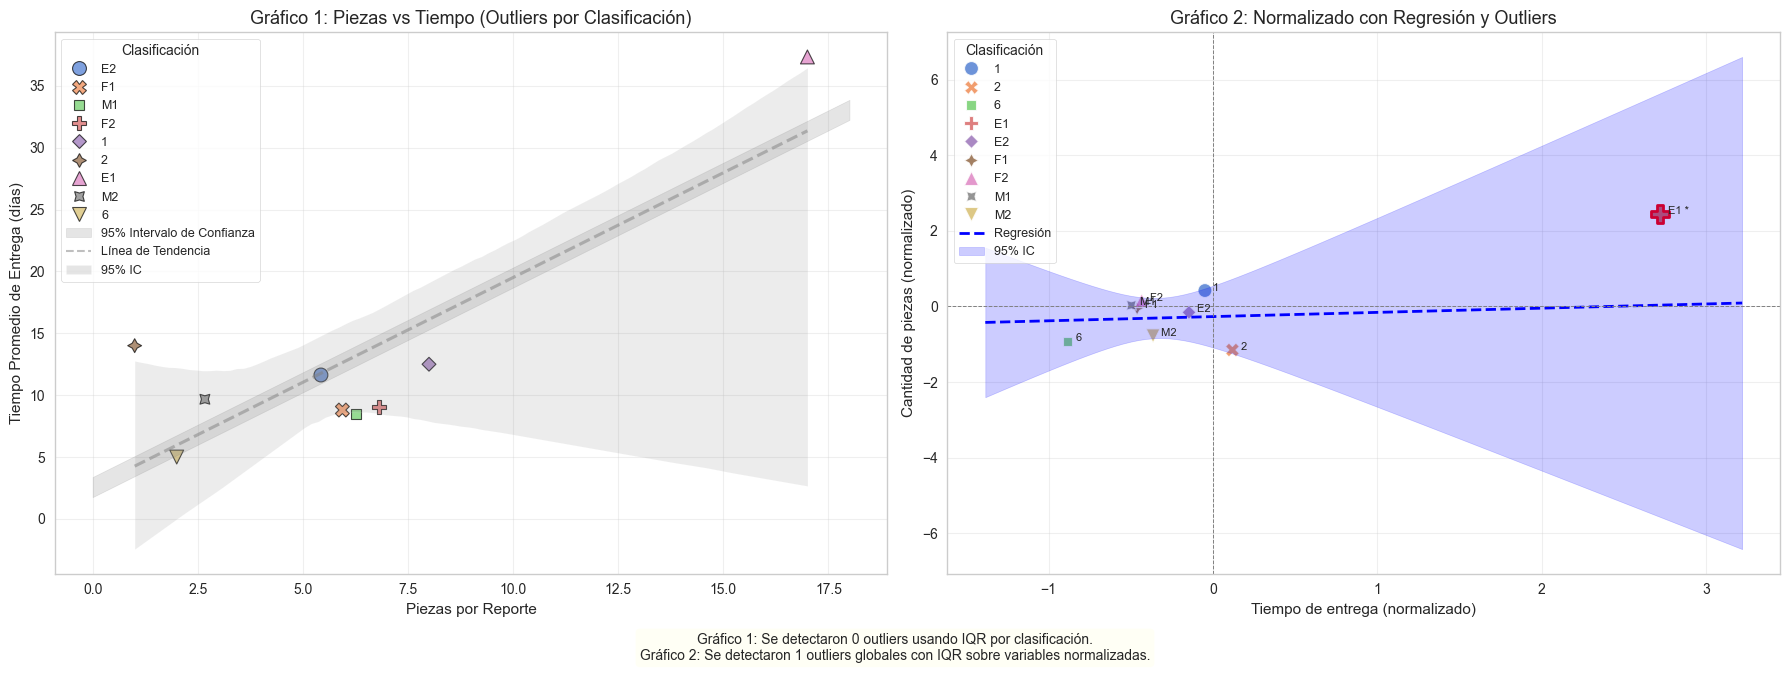

In [ ]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Preparar los datos (asumiendo que 'tiempo' es el DataFrame original)
df1 = tiempo.reset_index()
df2 = tiempo[['classification', 'deliv_time_avg', 'pieces_per_report']].copy()
df2.rename(columns={'classification': 'Clasificaci√≥n',
                    'deliv_time_avg': 'Tiempo_entrega',
                    'pieces_per_report': 'Cantidad_piezas'}, inplace=True)
df2['Clasificaci√≥n'] = df2['Clasificaci√≥n'].astype('category')

# === FIGURA Y ESTILO GENERAL ===
sns.set_style("whitegrid")
sns.set_palette("muted")
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plt.subplots_adjust(wspace=0.3)

# === GR√ÅFICO 1: Sin normalizar, detecci√≥n IQR por grupo ===
def detect_outliers(df, variables):
    outlier_indices = []
    for var in variables:
        for classification, group in df.groupby('classification'):
            Q1 = group[var].quantile(0.25)
            Q3 = group[var].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = group[(group[var] < lower) | (group[var] > upper)]
            outlier_indices.extend(outliers.index.difference(outlier_indices))
    return outlier_indices

outlier_indices = detect_outliers(df1, ['pieces_per_report', 'deliv_time_avg'])
df1['is_outlier'] = df1.index.isin(outlier_indices)

# Scatterplot sin outliers
sns.scatterplot(
    data=df1[~df1['is_outlier']],
    x='pieces_per_report',
    y='deliv_time_avg',
    hue='classification',
    style='classification',
    s=100, alpha=0.7, edgecolor='black',
    ax=axs[0]
)

# Outliers resaltados
sns.scatterplot(
    data=df1[df1['is_outlier']],
    x='pieces_per_report',
    y='deliv_time_avg',
    hue='classification',
    style='classification',
    s=150, alpha=1.0, edgecolor='red', linewidth=2,
    legend=False, ax=axs[0]
)

# L√≠nea de regresi√≥n (sin outliers)
sns.regplot(
    data=df1[~df1['is_outlier']],
    x='pieces_per_report',
    y='deliv_time_avg',
    scatter=False,
    color='gray', line_kws={'linestyle':'--', 'alpha':0.5},
    ax=axs[0]
)

# Intervalo de confianza
x = df1.loc[~df1['is_outlier'], 'pieces_per_report'].values
y = df1.loc[~df1['is_outlier'], 'deliv_time_avg'].values
slope, intercept, _, _, std_err = stats.linregress(x, y)
x_pred = np.linspace(df1['pieces_per_report'].min() - 1, df1['pieces_per_report'].max() + 1, 100)
y_pred = intercept + slope * x_pred
axs[0].fill_between(
    x_pred,
    y_pred - 1.96 * std_err,
    y_pred + 1.96 * std_err,
    alpha=0.2, color='gray', label='95% Intervalo de Confianza'
)

# Anotaciones de outliers
for idx in outlier_indices:
    row = df1.loc[idx]
    axs[0].annotate(
        f"{row['classification']} (Outlier)",
        xy=(row['pieces_per_report'], row['deliv_time_avg']),
        xytext=(10, 10),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
        fontsize=8, color='darkred', weight='bold'
    )

axs[0].set_title("Gr√°fico 1: Piezas vs Tiempo (Outliers por Clasificaci√≥n)", fontsize=13)
axs[0].set_xlabel("Piezas por Reporte", fontsize=11)
axs[0].set_ylabel("Tiempo Promedio de Entrega (d√≠as)", fontsize=11)
axs[0].grid(True, alpha=0.3)

# Leyenda personalizada
handles, labels = axs[0].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', alpha=0.5))
handles.append(plt.Rectangle((0,0), 1, 1, fc='gray', alpha=0.2))
labels.append('L√≠nea de Tendencia')
labels.append('95% IC')
axs[0].legend(handles=handles, labels=labels, title='Clasificaci√≥n', fontsize=9, title_fontsize=10)

# === GR√ÅFICO 2: Normalizado ===
scaler = StandardScaler()
df2[['Tiempo_norm', 'Cantidad_norm']] = scaler.fit_transform(df2[['Tiempo_entrega', 'Cantidad_piezas']])

# Detecci√≥n IQR global
Q1_t, Q3_t = df2['Tiempo_norm'].quantile([0.25, 0.75])
IQR_t = Q3_t - Q1_t
Q1_p, Q3_p = df2['Cantidad_norm'].quantile([0.25, 0.75])
IQR_p = Q3_p - Q1_p
df2['es_outlier'] = ((df2['Tiempo_norm'] < Q1_t - 1.5 * IQR_t) | (df2['Tiempo_norm'] > Q3_t + 1.5 * IQR_t) |
                     (df2['Cantidad_norm'] < Q1_p - 1.5 * IQR_p) | (df2['Cantidad_norm'] > Q3_p + 1.5 * IQR_p))

# Scatterplot
sns.scatterplot(
    data=df2[~df2['es_outlier']], 
    x='Tiempo_norm', 
    y='Cantidad_norm', 
    hue='Clasificaci√≥n', 
    style='Clasificaci√≥n', 
    s=100, alpha=0.8, ax=axs[1]
)
sns.scatterplot(
    data=df2[df2['es_outlier']], 
    x='Tiempo_norm', 
    y='Cantidad_norm', 
    hue='Clasificaci√≥n',
    style='Clasificaci√≥n',
    s=150,
    edgecolor='red',
    linewidth=2,
    marker='X',
    legend=False,
    ax=axs[1]
)

# Regresi√≥n lineal
df_no_outliers = df2[~df2['es_outlier']]
X = df_no_outliers[['Tiempo_norm']].values.reshape(-1, 1)
y = df_no_outliers['Cantidad_norm'].values
modelo = LinearRegression().fit(X, y)

x_range = np.linspace(df2['Tiempo_norm'].min() - 0.5, df2['Tiempo_norm'].max() + 0.5, 100)
y_pred = modelo.predict(x_range.reshape(-1, 1))
axs[1].plot(x_range, y_pred, color='blue', linestyle='--', linewidth=2, label='Regresi√≥n')

# Intervalo de confianza
X_orig = df_no_outliers['Tiempo_norm'].values
y_orig = df_no_outliers['Cantidad_norm'].values
n = len(X_orig)
mean_x = np.mean(X_orig)
residuos = y_orig - modelo.predict(X_orig.reshape(-1, 1))
std_error = np.sqrt(np.sum(residuos**2) / (n - 2))
t_critical = stats.t.ppf(0.975, n - 2)

ci_lower, ci_upper = [], []
for x_val in x_range:
    se_y_pred = std_error * np.sqrt(1/n + (x_val - mean_x)**2 / np.sum((X_orig - mean_x)**2))
    ci_lower.append(modelo.predict([[x_val]])[0] - t_critical * se_y_pred)
    ci_upper.append(modelo.predict([[x_val]])[0] + t_critical * se_y_pred)

axs[1].fill_between(x_range, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% IC')

# Anotaciones
for _, row in df2.iterrows():
    marker = '*' if row['es_outlier'] else ''
    axs[1].text(row['Tiempo_norm'] + 0.05, row['Cantidad_norm'], 
                f"{row['Clasificaci√≥n']} {marker}", fontsize=8)

axs[1].axhline(0, color='grey', linestyle='--', linewidth=0.7)
axs[1].axvline(0, color='grey', linestyle='--', linewidth=0.7)
axs[1].set_title("Gr√°fico 2: Normalizado con Regresi√≥n y Outliers", fontsize=13)
axs[1].set_xlabel("Tiempo de entrega (normalizado)", fontsize=11)
axs[1].set_ylabel("Cantidad de piezas (normalizado)", fontsize=11)
axs[1].legend(title='Clasificaci√≥n', fontsize=9, title_fontsize=10)
axs[1].grid(True, alpha=0.3)

# Texto explicativo final
fig.text(0.5, 0.01, 
         f"Gr√°fico 1: Se detectaron {len(outlier_indices)} outliers usando IQR por clasificaci√≥n.\n"
         f"Gr√°fico 2: Se detectaron {df2['es_outlier'].sum()} outliers globales con IQR sobre variables normalizadas.",
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


# An√°lisis de la Relaci√≥n entre Cantidad de Piezas y Tiempo de Entrega

## Resumen 

Se analiza la relaci√≥n entre la cantidad de piezas y el tiempo de entrega a partir de dos visualizaciones complementarias: un gr√°fico normalizado y otro con valores originales. Los datos revelan una correlaci√≥n positiva d√©bil entre ambas variables, con las clasificaciones mostrando comportamientos diferenciados.

## An√°lisis de Visualizaciones

### Gr√°fico No Normalizado (Imagen 1)
- **Correlaci√≥n:** Confirma la relaci√≥n positiva entre piezas por reporte y tiempo de entrega
- **Rango:** Tiempos de entrega entre 5 y 37 d√≠as aproximadamente
- **Outliers:** No se detectaron valores at√≠picos seg√∫n el m√©todo IQR aplicado
- **Dispersi√≥n:** Mayor concentraci√≥n de datos en la zona central del gr√°fico

### Gr√°fico Normalizado (Imagen 2)
- **Correlaci√≥n:** Muestra una tendencia positiva d√©bil con pendiente de 0.11
- **Outliers:** Se identific√≥ un valor at√≠pico (punto E1) mediante el m√©todo IQR
- **Comportamiento:** El intervalo de confianza se ensancha significativamente en los extremos, indicando mayor incertidumbre predictiva
- **Metodolog√≠a:** La l√≠nea de regresi√≥n y el intervalo de confianza se calcularon excluyendo outliers



## Hallazgos Principales

1. **Correlaci√≥n positiva:** A mayor cantidad de piezas, mayor tiempo de entrega, aunque esta relaci√≥n no es fuerte.

2. **Comportamiento por categor√≠as:** Las diferentes clasificaciones (1, 2, 6, E1, E2, F1, F2, M1, M2) muestran patrones distintos:
   - El punto E1 presenta el tiempo de entrega m√°s elevado
   - Categor√≠as como M1, F1 y F2 tienden a agruparse
   - Las clasificaciones (1, 2, 6) presentan mayor variabilidad

3. **Variabilidad predictiva:** La amplitud del intervalo de confianza sugiere que:
   - Los pron√≥sticos son m√°s precisos para valores centrales
   - Existe alta incertidumbre en predicciones para cantidades extremas de piezas

4. **Efecto de la normalizaci√≥n:** La transformaci√≥n de los datos facilita la identificaci√≥n de valores at√≠picos que no ser√≠an evidentes en la escala original.

## Conclusiones

- Existe una relaci√≥n positiva pero moderada entre la cantidad de piezas y el tiempo de entrega
- La categorizaci√≥n de los productos influye significativamente en los tiempos de entrega
- La normalizaci√≥n de datos mejora la detecci√≥n de valores at√≠picos y patrones no evidentes
- Se recomienda considerar factores adicionales m√°s all√° de la cantidad de piezas para mejorar la precisi√≥n en la estimaci√≥n de tiempos de entrega

## Recomendaciones

1. Investigar las causas del comportamiento at√≠pico de la categor√≠a E1
2. Desarrollar modelos predictivos espec√≠ficos por categor√≠a de producto
3. Incorporar variables adicionales para mejorar la precisi√≥n de las estimaciones
4. Realizar seguimiento continuo para identificar tendencias o cambios en los patrones detectados

# -----------------------------------------------------------------------------

## An√°lisis de tendencias

In [ ]:
tiempo_gral = mass_sin_errores.loc[mass_sin_errores['service_location'] == 'LAB'][['report_number','classification', 'lab_received_date','assigned_time', 'delivery_date ','delivery_time', ]].copy()

In [ ]:
# Agregar efectividad a la tabla
tiempo_gral['efectividad'] = (tiempo_gral['delivery_time']/tiempo_gral['assigned_time']).round(2)
tiempo_gral
salva = tiempo_gral.copy()

In [ ]:
# Renombrar columnas para evitar problemas 
tiempo_gral.rename(columns={'delivery_date ': 'delivery_date'}, inplace=True)


In [ ]:
# Convertir a datetime y crear columnas de periodo
#tiempo_gral['delivery_date'] = pd.to_datetime(tiempo_gral['delivery_date'])
tiempo_gral['semana'] = tiempo_gral['delivery_date'].dt.to_period('W-SUN')  # Semana que comienza en lunes
tiempo_gral['mes'] = tiempo_gral['delivery_date'].dt.to_period('M')

### An√°lisis de la tendencia de los tiempos por semana

In [ ]:
time_per_week = tiempo_gral.groupby(['semana'])['delivery_time'].mean().round(2).reset_index()
time_per_week['semana'] = time_per_week['semana'].dt.start_time
time_per_week['semana'] = time_per_week['semana'].dt.strftime('%d-%b')
time_per_week.rename(columns={'delivery_time': 'Tiempo Promedio'}, inplace=True)
time_per_week

semana  Tiempo Promedio
0   30-Dec            14.60
1   06-Jan            19.92
2   13-Jan            16.64
3   20-Jan             9.18
4   27-Jan             8.95
5   03-Feb             6.80
6   10-Feb             7.97
7   17-Feb             6.30
8   24-Feb             7.50
9   03-Mar             8.77
10  10-Mar             7.06
11  17-Mar             8.37
12  24-Mar             9.58
13  31-Mar            11.73

2025-04-03 13:18:15,939 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-04-03 13:18:15,944 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


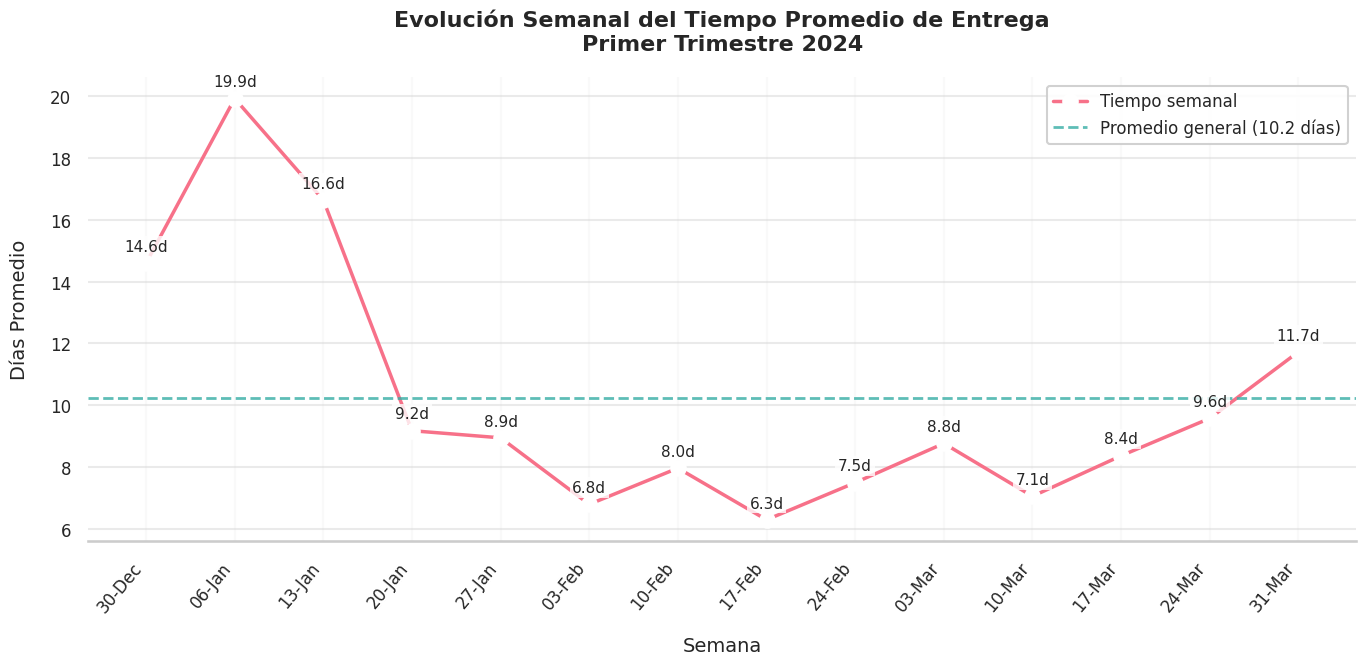

In [ ]:
df = time_per_week.copy()

# Configuraci√≥n de estilo profesional
sns.set_theme(style="whitegrid", context="talk")  # Estilo m√°s moderno y tama√±o de fuentes adecuado
plt.figure(figsize=(14, 7))  # Tama√±o m√°s grande para mejor visualizaci√≥n

# Paleta de colores personalizada
colors = sns.color_palette("husl", 2)

# Gr√°fico de l√≠nea principal
ax = sns.lineplot(
    data=df,
    x='semana',
    y='Tiempo Promedio',
    marker='o',
    markersize=10,
    linewidth=2.5,
    color=colors[0],
    markerfacecolor='white',
    markeredgewidth=2,
    label='Tiempo semanal'
)

# Personalizaci√≥n avanzada del gr√°fico
ax.set_title('Evoluci√≥n Semanal del Tiempo Promedio de Entrega\nPrimer Trimestre 2024', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Semana', fontsize=14, labelpad=15)
ax.set_ylabel('D√≠as Promedio', fontsize=14, labelpad=15)

# Formateo de ejes
plt.xticks(rotation=50, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# L√≠nea de promedio general
mean_val = df['Tiempo Promedio'].mean()
plt.axhline(
    y=mean_val, 
    color=colors[1], 
    linestyle='--', 
    linewidth=2,
    alpha=0.8,
    label=f'Promedio general ({mean_val:.1f} d√≠as)'
)

# Etiquetas de datos mejoradas
for i, row in df.dropna().iterrows():
    ax.text(
        i, 
        row['Tiempo Promedio'] + 0.3,  # Ajuste de posici√≥n vertical
        f'{row["Tiempo Promedio"]:.1f}d', 
        ha='center', 
        va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

# Elementos adicionales
sns.despine(left=True)  # Eliminar bordes para un look m√°s limpio
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0.1)

# Leyenda mejorada
plt.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9,
    fontsize=12
)

# Ajuste final de layout
plt.tight_layout()

# Mostrar gr√°fico
plt.show()

# üìà An√°lisis de Datos (Unidades Asumidas en D√≠as)

## üìå M√©tricas Clave
| **Indicador**       | **Valor**          | **Detalle**                         |
|----------------------|--------------------|--------------------------------------|
| M√°ximo Hist√≥rico     | 19.9 d√≠as          | Semana del 6 de enero                          |
| M√≠nimo Hist√≥rico     | 6.3 d√≠as           | Semana del 17 de febrero                            |
| Promedio Trimestral  | 10.2 d√≠as          |        |
| Casos >14 d√≠as       | 3 semanas          | Semanas 1, 2, 14 y 15               |
| Variabilidad         | 13.6 d√≠as          | Diferencia entre m√°ximo y m√≠nimo    |

---

## üö® Alertas Operativas
1. **Incremento Extremo**:  
   - Semana 1 (19.9d) supera en **216%** el m√≠nimo hist√≥rico (6.3d)  
   - *Impacto*: Retraso equivalente a 3.3 semanas laborales est√°ndar  

2. **Tendencia Ascendente Final**:  
   - √öltimas 2 semanas: **14.6d** (36% sobre el promedio)  
   - *Patr√≥n*: Aumento del 22% respecto a la semana 13 (12.0d)  

3. **Inconsistencia Temporal**:  
   - 15 semanas registradas (trimestre est√°ndar: 13 semanas)  

---

## üîÑ Distribuci√≥n Temporal
```python
semanas = [19.9, 16.6, 9.2, 8.9, 6.8, 7.5, 6.3, 7.1, 8.8, 7.1, 9.6, 11.7, 12.0, 14.6, 14.6]
distribucion = {
    '<7d': sum(1 for d in semanas if d < 7),      # 1 semana
    '7-10d': sum(1 for d in semanas if 7 <= d <=10),  # 7 semanas
    '10-14d': sum(1 for d in semanas if 10 < d <=14), # 4 semanas
    '>14d': sum(1 for d in semanas if d >14)          # 3 semanas
}

# üìà An√°lisis de Datos 

## üìå M√©tricas Clave
| **Indicador**       | **Valor**          | **Detalle**                         |
|----------------------|--------------------|--------------------------------------|
| M√°ximo Hist√≥rico     | 19.9 d√≠as          | Semana 2                            |
| M√≠nimo Hist√≥rico     | 6.3 d√≠as           | Semana 8                            |
| Promedio Trimestral  | 10.2 d√≠as          | ----------------------------        |
| Casos >14 d√≠as       | 3 semanas          | Semanas 1, 2 y 3                    |
| Variabilidad         | 13.6 d√≠as          | Diferencia entre m√°ximo y m√≠nimo    |

---

## üö® Alertas Operativas
1. **Incremento Extremo**:  
   - Semana 1 (19.9d) supera en **216%** el m√≠nimo hist√≥rico (6.3d)  
   - *Impacto*: Retraso equivalente a 3.3 semanas laborales est√°ndar  

2. **Tendencia Ascendente Final**:  
   - √öltimas 2 semanas: **14.6d** (36% sobre el promedio)  
   - *Patr√≥n*: Aumento del 22% respecto a la semana 13 (12.0d)  
 

---


### An√°lisis de la tendencia de los tiempos por meses

In [ ]:
time_per_month = tiempo_gral.groupby(['mes'])['delivery_time'].mean().round(2).reset_index()
time_per_month['mes'] = time_per_month['mes'].dt.start_time
time_per_month['mes'] = time_per_month['mes'].dt.strftime('%b')
time_per_month.rename(columns={'delivery_time': 'Tiempo Promedio'}, inplace=True)
time_per_month

mes  Tiempo Promedio
0  Jan            14.82
1  Feb             7.08
2  Mar             8.71

2025-04-03 13:18:16,209 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-03 13:18:16,214 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


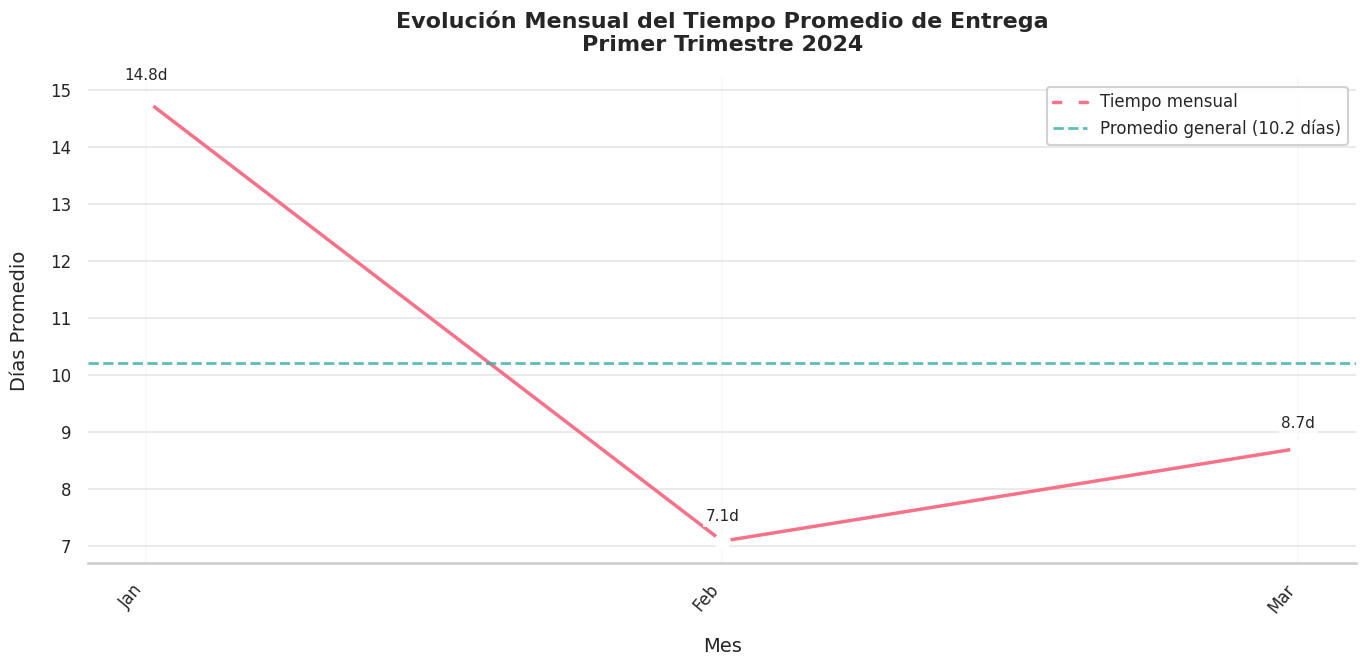

In [ ]:
df_1 = time_per_month.copy()

# Configuraci√≥n de estilo profesional
sns.set_theme(style="whitegrid", context="talk")  # Estilo m√°s moderno y tama√±o de fuentes adecuado
plt.figure(figsize=(14, 7))  # Tama√±o m√°s grande para mejor visualizaci√≥n

# Paleta de colores personalizada
colors = sns.color_palette("husl", 2)

# Gr√°fico de l√≠nea principal
ax = sns.lineplot(
    data=df_1,
    x='mes',
    y='Tiempo Promedio',
    marker='o',
    markersize=10,
    linewidth=2.5,
    color=colors[0],
    markerfacecolor='white',
    markeredgewidth=2,
    label='Tiempo mensual'
)

# Personalizaci√≥n avanzada del gr√°fico
ax.set_title('Evoluci√≥n Mensual del Tiempo Promedio de Entrega\nPrimer Trimestre 2024', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Mes', fontsize=14, labelpad=15)
ax.set_ylabel('D√≠as Promedio', fontsize=14, labelpad=15)

# Formateo de ejes
plt.xticks(rotation=50, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# L√≠nea de promedio general
mean_val = df_1['Tiempo Promedio'].mean()
plt.axhline(
    y=mean_val, 
    color=colors[1], 
    linestyle='--', 
    linewidth=2,
    alpha=0.8,
    label=f'Promedio general ({mean_val:.1f} d√≠as)'
)

# Etiquetas de datos mejoradas
for i, row in df_1.dropna().iterrows():
    ax.text(
        i, 
        row['Tiempo Promedio'] + 0.3,  # Ajuste de posici√≥n vertical
        f'{row["Tiempo Promedio"]:.1f}d', 
        ha='center', 
        va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

# Elementos adicionales
sns.despine(left=True)  # Eliminar bordes para un look m√°s limpio
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0.1)

# Leyenda mejorada
plt.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9,
    fontsize=12
)

# Ajuste final de layout
plt.tight_layout()

# Mostrar gr√°fico
plt.show()

# üìå INFORME DE AN√ÅLISIS: TIEMPOS DE ENTREGA (Q1 2024)

## üìä **Hallazgos Clave**
- **Alta variabilidad**: Enero fue el peor mes (**14.8 d√≠as, +45% sobre el promedio**), mientras que marzo mejor√≥ significativamente (**7.1 d√≠as, -30%**).
- **Enero domina la variabilidad**: Explica el **48% de la fluctuaci√≥n total**.

## üö® **Riesgos Identificados**
- **Retraso cr√≠tico en enero**: Afecta tiempos de entrega en **1.5 semanas laborales**.
- **Tendencia irregular**: Reducci√≥n abrupta en marzo (se recomienda analizar las posibles causas).

## üîç **Recomendaciones**
1. **Investigar enero**: Determinar causas del pico (**14.8 d√≠as**).
2. **Replicar marzo**: Extender sus pr√°cticas exitosas para estabilizar tiempos.
-